# Исследование игрового рынка

## Описание проекта
**Дано:** датасет с названием игры, жанром и игровой платформой, годом выпуска, продажами в разных регионах, оценками критиков и пользователей, возрастным рейтингом.

**Цель:** необходимо выявить определяющие успешность игры закономерности для того, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**План работы:**
- Загрузка и подготовка данных
- Исследовательский анализ данных
- Составьление портрета пользователя каждого региона
- Проверька гипотез
- Общий вывод

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import warnings

warnings.filterwarnings('ignore')

В исходном датаврейме 16715 строк и 11 столбцов:
- `'Name'` — название игры
- `'Platform'` — платформа
- `'Year_of_Release'` — год выпуска
- `'Genre'` — жанр игры
- `'NA_sales'` — продажи в Северной Америке (миллионы проданных копий)
- `'EU_sales'` — продажи в Европе (миллионы проданных копий)
- `'JP_sales'` — продажи в Японии (миллионы проданных копий)
- `'Other_sales'` — продажи в других странах (миллионы проданных копий)
- `'Critic_Score'` — оценка критиков (максимум 100)
- `'User_Score'` — оценка пользователей (максимум 10)
- `'Rating'` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


Первое что можно заметить - в названиях столбцов имеются прописные буквы.

Также имеются столбцы с пропущенными данными. Так, в `'Critic_Score'` отсутствует более половины значений, а в `'User_Score'` и `'Rating'` по 40%.

Некоторые столбцы имеют неверный формат: например, столбец с годом релиза однозначно должен быть целочисленным. 

In [2]:
from io import BytesIO
import requests
spreadsheet_id = '1hSkAP3VuEdx8FXqKw3CTdaTHz7WS8Y0Rr9quBsiPWXI'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.isna().agg(['sum', 'mean']).round(2).T.sort_values(by='sum', ascending=False)

,sum,mean
Critic_Score,8578.0,0.51
Rating,6766.0,0.40
User_Score,6701.0,0.40
Year_of_Release,269.0,0.02
Name,2.0,0.00
Genre,2.0,0.00
Platform,0.0,0.00
NA_sales,0.0,0.00
EU_sales,0.0,0.00
JP_sales,0.0,0.00


# 1. Подготовка данных

Привожу название столбцов к нижнему регистру

In [5]:
df.columns = df.columns.str.lower()

Столбец с датой выхода игры `'year_of_release'` из-за наличия `NaN` не может быть изменен на `int`. Исправляю это.

Смотрю кол-во пропусков в этом столбце. Их 269. Но, в названиях спортивных игр (Sports, Fighting, Racing) уже имется информация о годе релиза. Например, FIFA Soccer 2004 вышла в 2003 году. Пишу функцию, извлекающую из названий спортивных игр дату релиза

In [6]:
# сохраняю только спортивные игры без года релиза
sports_year_nan = df.loc[(df['year_of_release'].isna()) & ((df['genre']=='Sports') | (df['genre']=='Fighting') | (df['genre']=='Racing')), 'name']
print('Кол-во спортивных игр с отсутствующей датой релиза:', len(sports_year_nan))

Кол-во спортивных игр с отсутствующей датой релиза: 77


In [7]:
def year_of_release_sports(row):
    """Функция, извлекающая из названий спортивных игр год релиза"""
    for i in '0123456789':   # проверяю наличие цифр в названии
        if i in row:
            s = row.split()
            s[-1] = s[-1].replace('K', '00')    # преобразуем 2К6 на 2006
            s[-1] = s[-1].replace('-', '')      # удаляем дефисы, где они есть
            if len(s[-1]) == 4:
                return int(s[-1]) - 1
            if len(s[-1]) == 2:
                if 80 < int(s[-1]) < 100:       # если игра выпустилась с 1980 по 2000
                    return 1900 + int(s[-1]) - 1
                elif int(s[-1]) <= 16:
                    return 2000 + int(s[-1]) - 1

Продолжаю работать с копией датафрейма `data`. Применяю заполние пропусков найденными значениями года релиза спортивных игр. Убеждаюсь в правильности заполнения, сведя название игры и извлеченного года релиза в общюю таблицу

In [8]:
data = df.copy()
usl = (data['year_of_release'].isna()) & ((data['genre']=='Sports') | (data['genre']=='Fighting') | (data['genre']=='Racing'))
data.loc[usl, 'year_of_release'] = data.loc[usl, 'name'].apply(year_of_release_sports)


sports_year_nan = sports_year_nan.reset_index()
sports_year_nan.merge(data.loc[sports_year_nan['index'], 'year_of_release'].reset_index(), on='index', how='outer')

,index,name,year_of_release
0,183,Madden NFL 2004,2003.0
1,377,FIFA Soccer 2004,2003.0
2,475,wwe Smackdown vs. Raw 2006,2005.0
3,1301,Triple Play 99,1998.0
4,1650,NASCAR Thunder 2003,2002.0
...,...,...,...
72,16079,Football Manager 2007,2006.0
73,16080,Ferrari: The Race Experience,NaN
74,16180,WRC: FIA World Rally Championship,NaN
75,16373,PDC World Championship Darts 2008,2007.0


Заполняю пропуски нулями и изменим тип на `int`.

In [9]:
data['year_of_release'] = data['year_of_release'].fillna(0).astype('int')
data.loc[data['year_of_release']==0, 'name'].unique()

array(['LEGO Batman: The Videogame', 'Space Invaders', 'Rock Band',
       "Frogger's Adventures: Temple of the Frog",
       'LEGO Indiana Jones: The Original Adventures', 'Call of Duty 3',
       'Call of Duty: Black Ops', 'Adventure', 'Combat',
       'LEGO Harry Potter: Years 5-7', 'Hitman 2: Silent Assassin',
       'Legacy of Kain: Soul Reaver', 'Donkey Kong Land III',
       'Air-Sea Battle', 'Suikoden III', 'Wheel of Fortune', 'Yakuza 4',
       'Namco Museum', 'Rhythm Heaven',
       'The Lord of the Rings: War in the North',
       'Shaun White Snowboarding', 'PES 2009: Pro Evolution Soccer',
       'WarioWare: Twisted!', 'Test Drive Unlimited 2',
       'The Chronicles of Narnia: The Lion, The Witch and The Wardrobe',
       'Monster Hunter 2', 'Metal Gear Solid 2: Substance',
       'Advance Wars: Days of Ruin', 'The Golden Compass',
       'NASCAR: Dirt to Daytona', 'Def Jam: Fight for NY',
       'NBA Street Vol. 2', 'Fishing Derby', 'Wet', 'Sonic the Hedgehog',
       'K

Также выяснилось, что у написанная функция не справилась c `'PES 2009: Pro Evolution Soccer'` и не учла `'Tomb Raider (2013)'`. Запишу даты релиза этих игр вручную. Оставшиеся пропущенные значения можно либо заполнить медианным значением относительно игровой платформы, на которой они выходили, либо удалить их, так как подобных значений мало (243 или 1.4%). Я предпочел третий вариат, отметив такие игры маркером 0.

In [10]:
data.loc[data['name']=='PES 2009: Pro Evolution Soccer', 'year_of_release'] = 2008
data.loc[data['name']=='Tomb Raider (2013)', 'year_of_release'] = 2013

Сразу же смотрю общее распределение выпущенных игр по годам в долях. До 2008 года объем выпущенных игр увеличевался, однако после начал падать. Причины этого попробую выяснить во время анализа следующих данных.

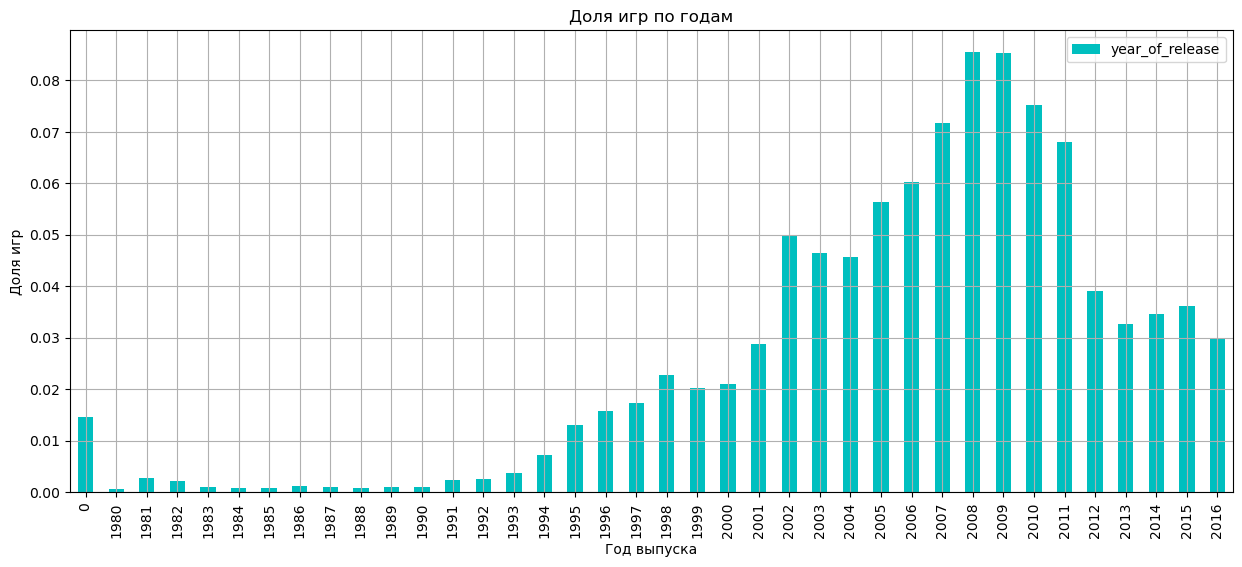

In [11]:
(
data['year_of_release'].value_counts(normalize=True)
                     .reset_index()
                     .sort_values(by='index')
                     .plot(y='year_of_release', x='index', kind='bar', figsize=(15, 6), color='c', grid=True, 
                           title='Доля игр по годам', xlabel='Год выпуска', ylabel='Доля игр')
);

In [12]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В столбце `'name'` отсвутсвуют названия двух игр. Более того, у них отсутвуют и рейтинги. Данные игры не подойдут для нашего исследования, поэтому удалю их. Повторяющихся игр в таблице нет.

In [13]:
data = data.dropna(subset=['name'])
data[data.duplicated(subset=['name', 'platform'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T
4127,Sonic the Hedgehog,PS3,0,Platform,0.0,0.48,0.00,0.00,43.0,4.1,E10+
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E


В столбце `'platform'` нет странностей в названиях. В добавок, он не имеет пропусков. Смотрю долю игр по платформам. Можно наблюдать, что за все время, что охватывает наш датафрейм (до 2016) подавляющее количество игр выходило на PS2 и на DS, следом расположились PS Wii и PSP. Интересно посмотреть распределение по годам. Воспользуюсь тепловой картой

''

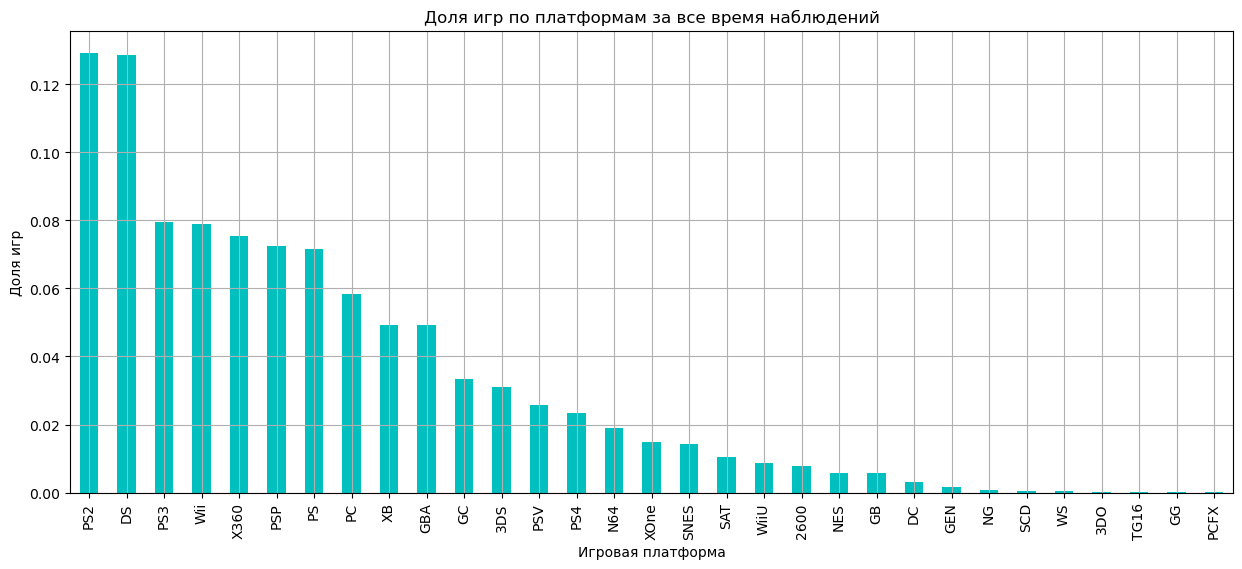

In [14]:
(
data['platform'].value_counts(normalize=True)
    .plot(kind='bar', figsize=(15, 6), color='c', grid=True, title='Доля игр по платформам за все время наблюдений',
         xlabel='Игровая платформа', ylabel='Доля игр'))
;

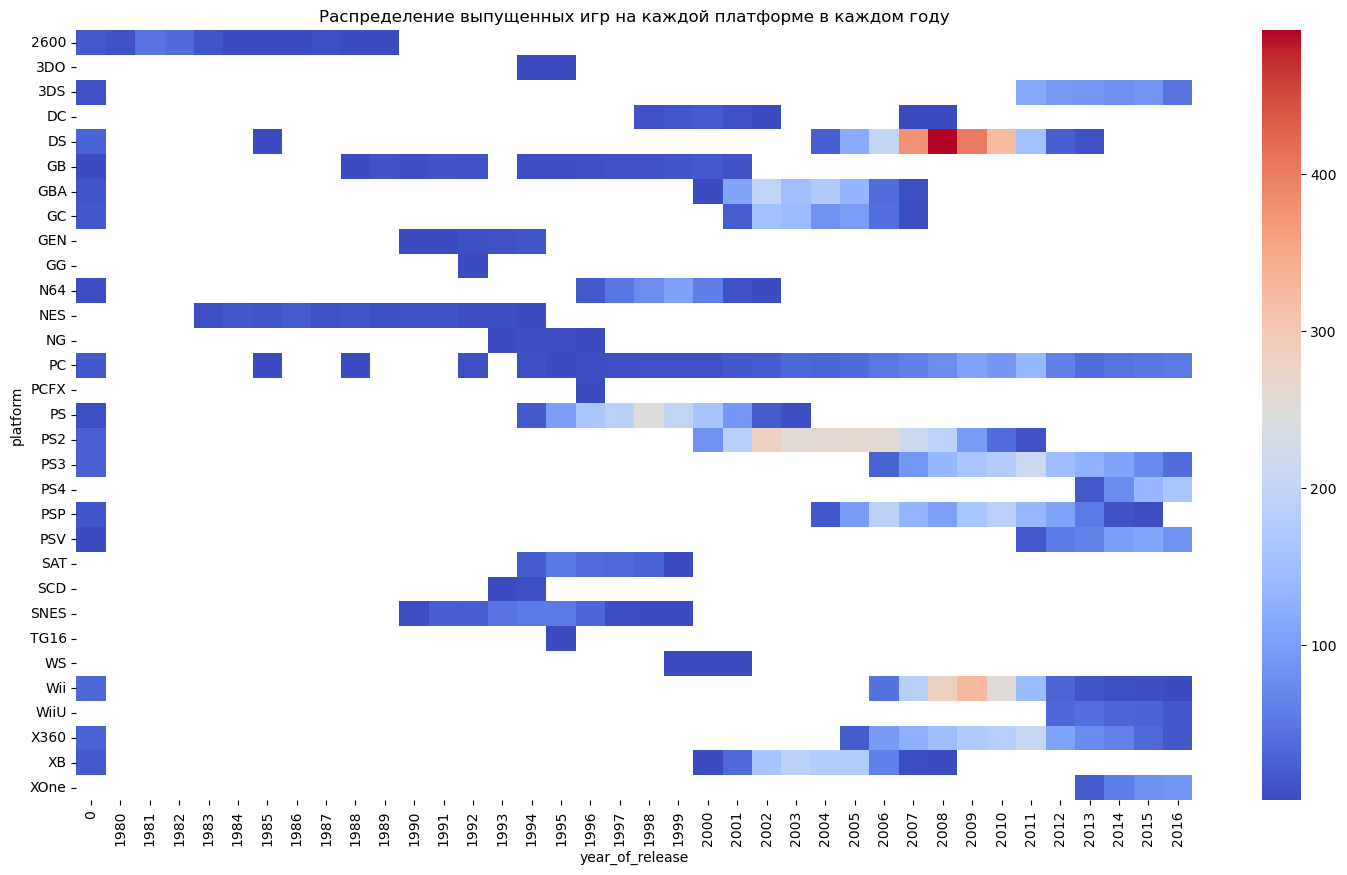

In [15]:
plt.figure(figsize=(18,10))
plt.title('Распределение выпущенных игр на каждой платформе в каждом году')
plt.xlim(1980, 2016)
sns.heatmap(data.pivot_table(index='platform', columns='year_of_release', values='name', aggfunc='count'), cmap='coolwarm');

count    31.000000
mean      7.612903
std       6.998464
min       0.000000
25%       3.000000
50%       6.000000
75%      10.000000
max      31.000000
Name: life, dtype: float64

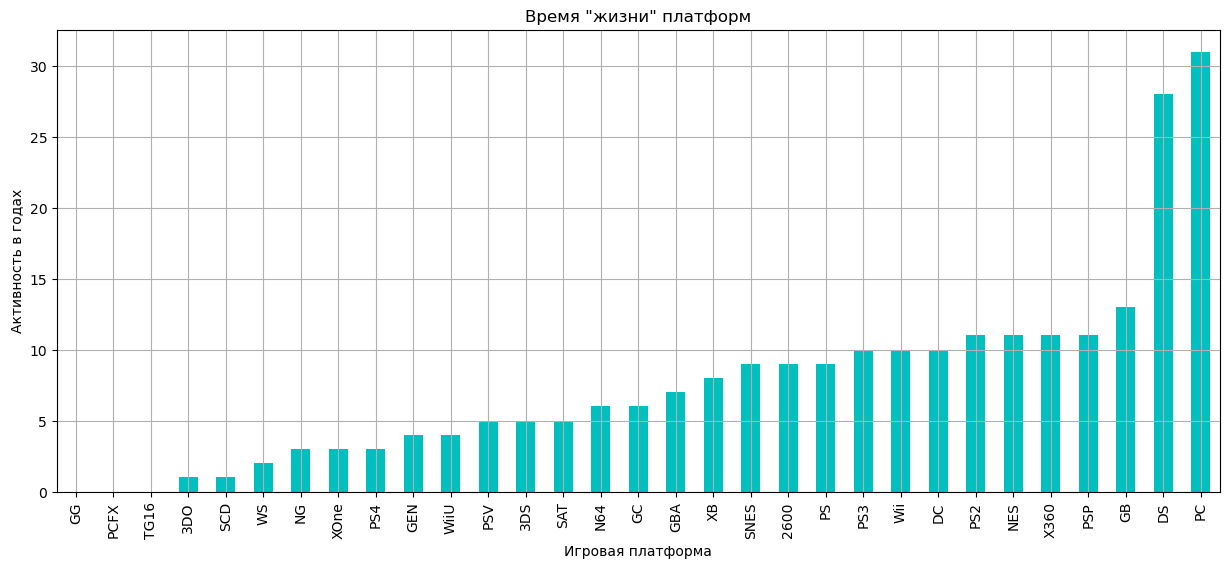

In [16]:
# Время 'жизини' платформ
platform_life = data.query('year_of_release > 0').groupby('platform')['year_of_release'].agg(['min', 'max'])
platform_life['life'] = platform_life['max'] - platform_life['min']
(
platform_life['life']
    .sort_values()
    .plot(kind='bar', figsize=(15, 6), color='c', grid=True, title='Время "жизни" платформ',
         xlabel='Игровая платформа', ylabel='Активность в годах')
);

platform_life['life'].describe()

Помимо количества выпущенных игр на каждой из платформ за каждый год на тепловой диаграмме таже можно увидеть срок "жизни" каждой из платформ. Например, игры на легендарную PS выходили c 1994го года по 2003 (9 лет!). Популярность этой консоли постепенно уменьшалась с выходом PS2. Несмотря на то, что по количеству выпущенных игр ПК гейминг занимает 8е место, он самый продолжительный. Также можно заметить, что поклонникам корманных игровых приставок всегда имеют большой выбор в играх. В этом сегменте лидирует DS консоль. Но количество выпущенных игр еще не говорит о популярности игры - это исследуем чуть позже.

Также частично можно ответить на вопрос, почему после 2008 года количество выпускаемых игр стало уменьшаться. Помимо всемирного финансового кризиса, перестала поддерживаться консоль XB (9я в топе по доле). Игры на самых популярных консолях также стали выходить в меньших количествах. Возможно, дело в качестве игр: производители стали делать упор на крупнобюджетных играх?

Среднее время жизни консоли составляе 7.6 лет (медианное 6 лет). Этот покажатель не справедлив для PC, благодаря его возможности кастомизации и обновления. Иц традиционных игровых платформ долгожителем является DS.

Перейдем к жанрам. В колонке отсутсвуют пропуски. Больше всего игр выпущено в жанре Action, при том их популярность растет с 2001 года. Выторым по популярности жанром является Sports. Третим - Misc (разное). Также можно заметить, что некоторые жанры появились или начали регулярно выпускаться только с 1991 года.

Кол-во пропусков: 0


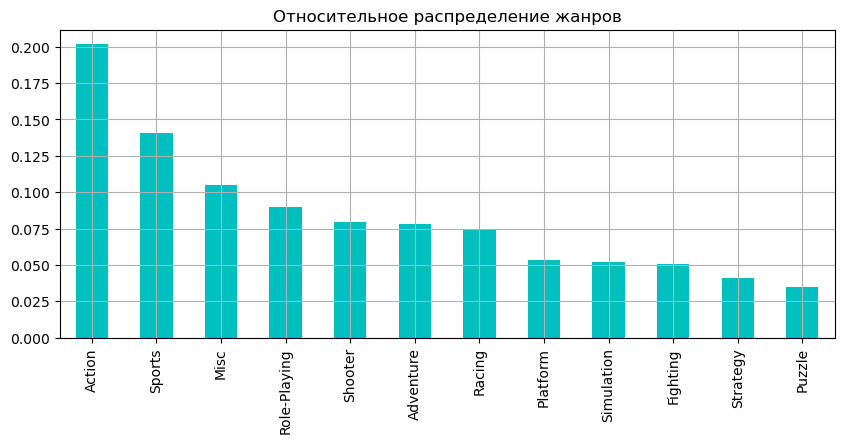

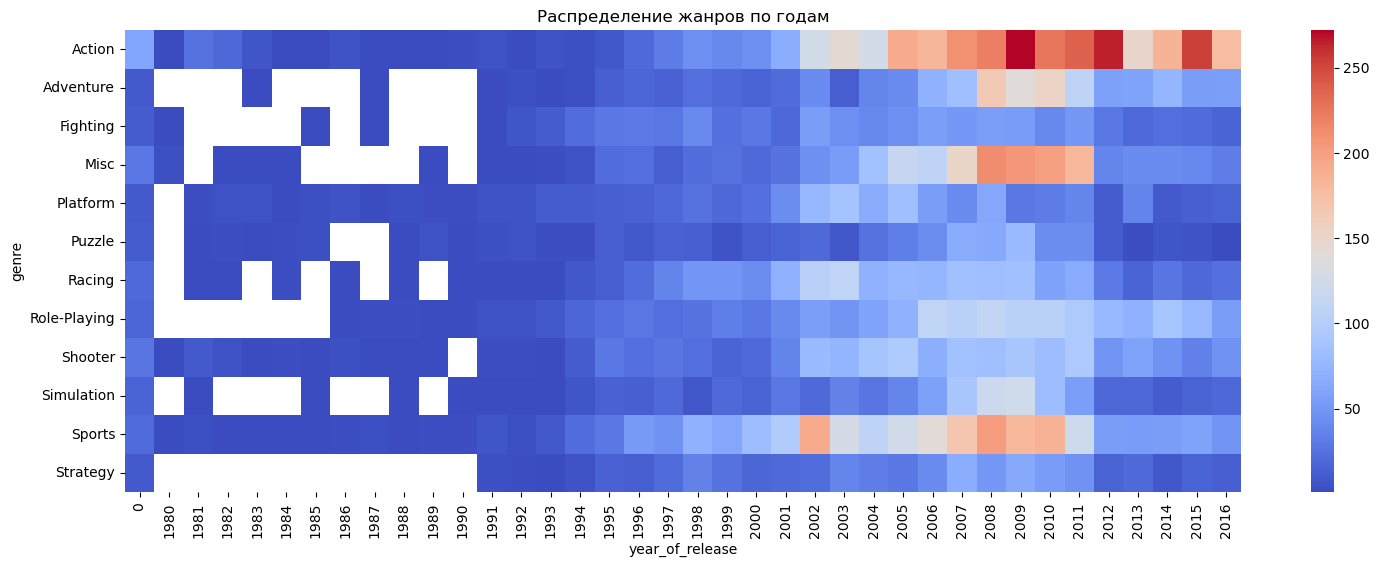

In [17]:
print('Кол-во пропусков:', data['genre'].isna().sum())

(
data['genre'].value_counts(normalize=True)
    .plot(kind='bar', color='c', grid=True, figsize=(10, 4), title='Относительное распределение жанров')
);

plt.figure(figsize=(18,6))
plt.title('Распределение жанров по годам')
sns.heatmap(data.pivot_table(index='genre', columns='year_of_release', values='name', aggfunc='count'), cmap='coolwarm');
plt.show()

Следущие на очереди столбцы с продажами в Северной Америке, Европе, Японии и в остальном мире. Создаю для каждой игре столбец с общими продажами. Сразу смотрю топ самых продаваемых игр.

In [18]:
data['total_sales'] = data.loc[:, 'na_sales': 'other_sales'].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [19]:
data[['name','genre','year_of_release', 'total_sales']].sort_values(by='total_sales', ascending=False).head(10)

,name,genre,year_of_release,total_sales
0,Wii Sports,Sports,2006,82.54
1,Super Mario Bros.,Platform,1985,40.24
2,Mario Kart Wii,Racing,2008,35.52
3,Wii Sports Resort,Sports,2009,32.77
4,Pokemon Red/Pokemon Blue,Role-Playing,1996,31.38
5,Tetris,Puzzle,1989,30.26
6,New Super Mario Bros.,Platform,2006,29.80
7,Wii Play,Misc,2006,28.91
8,New Super Mario Bros. Wii,Platform,2009,28.32
9,Duck Hunt,Shooter,1984,28.31


Самыми продаваемыми оказалась игры Wii Sports, Super Mario Bros. и Mario Kart Wii.Смотрю на распределение выручки по годам. Она естественно будет подобна распределению количества выпущенных игр по годам. Однако, средняя выручка с единицы игры паказывает обратный характер. Выручка с одной игры у игр до 1992 выше, чем после 1992 года. На графике выделяются игры из топ10: Duck Hunt, Super Mario Bros и Tetris.

Их игровых платформ наибольшей популярностью пользовались GB и NES (оно не удивительно, ведь на них выходили самые легендарные игры - 4 из топ10)

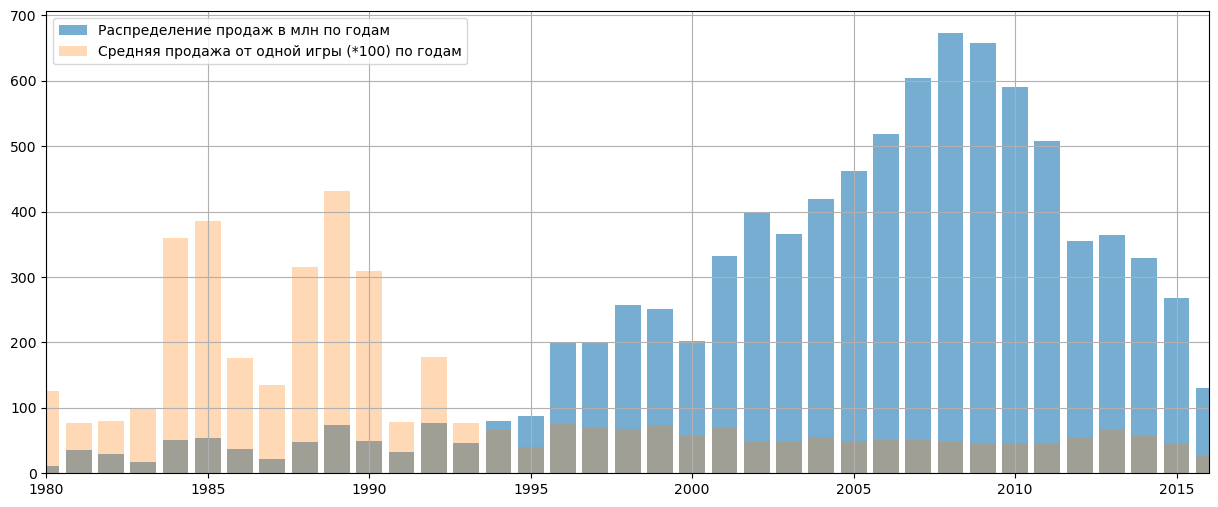

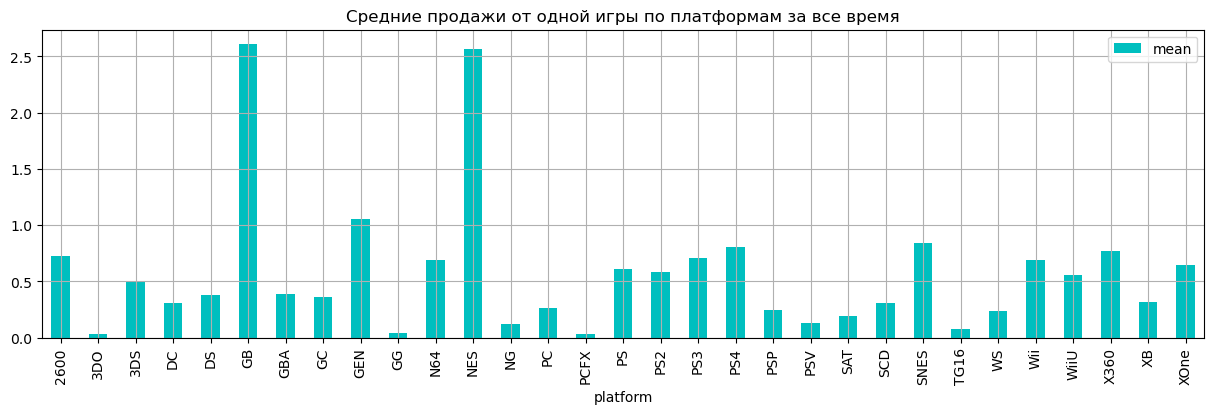

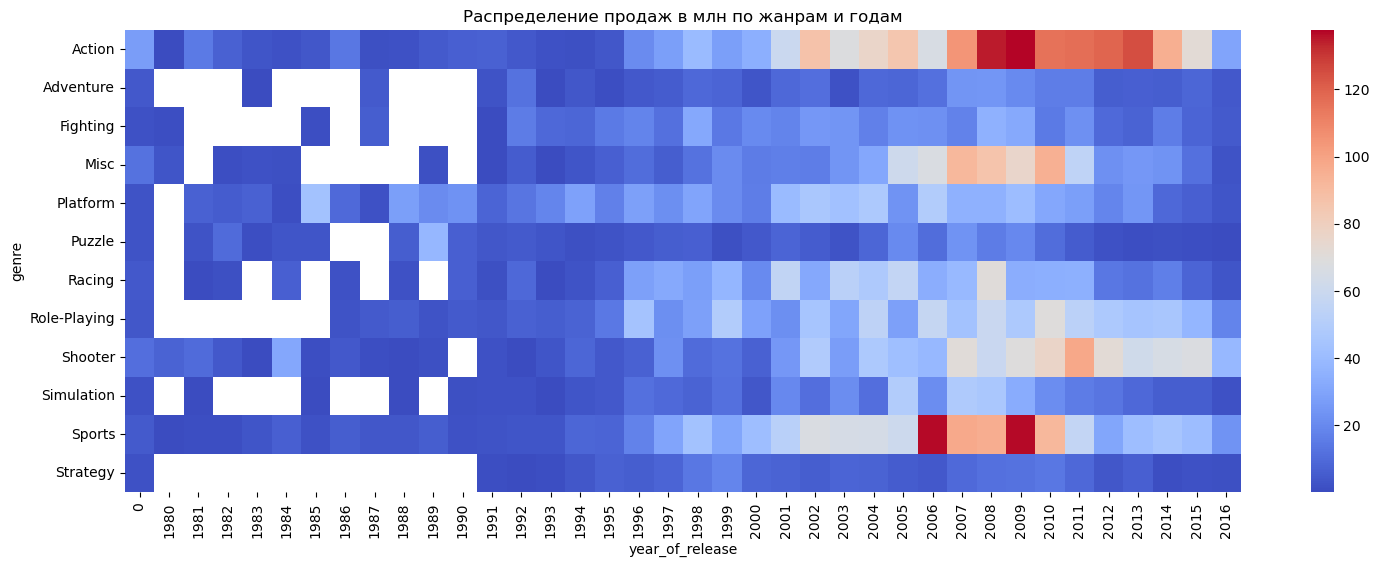

In [20]:
total_sales_year = data.groupby('year_of_release')['total_sales'].agg(['sum', 'mean'])
plt.figure(figsize=(15,6))
plt.bar(total_sales_year.index, total_sales_year['sum'], alpha=0.6, label='Распределение продаж в млн по годам')
plt.bar(total_sales_year.index, total_sales_year['mean']*100, alpha=0.3, label='Средняя продажа от одной игры (*100) по годам')
plt.legend()
plt.xlim(1980, 2016)
plt.grid()

(
data.groupby('platform')['total_sales'].agg(['mean'])
    .plot(kind='bar', color='c', grid=True, figsize=(15, 4), title='Средние продажи от одной игры по платформам за все время')
)
    
plt.figure(figsize=(18,6))
plt.title('Распределение продаж в млн по жанрам и годам')
sns.heatmap(data.pivot_table(index='genre', columns='year_of_release', values='total_sales', aggfunc='sum'), cmap='coolwarm');
plt.show()

In [21]:
#Самые продаваемые игры двух самых популярных платформ
data.loc[(data['platform'] == 'GB') | (data['platform'] == 'NES')].sort_values(by='total_sales', ascending=False)['name'].head(10)

1                           Super Mario Bros.
4                    Pokemon Red/Pokemon Blue
5                                      Tetris
9                                   Duck Hunt
12                Pokemon Gold/Pokemon Silver
21                           Super Mario Land
22                        Super Mario Bros. 3
30    Pokémon Yellow: Special Pikachu Edition
50         Super Mario Land 2: 6 Golden Coins
98                        Super Mario Bros. 2
Name: name, dtype: object

Строю «ящик с усами» по глобальным продажам игр в разбивке по платформам. Это позволит понять распределение продаж в период 'жизни' каждой платформы. Самые большие продажи у PS2, Wii, X360, PS, DS. PS4, как преемнник PS3, бодро ворвалась в игровой мир - 25% продаж не ниже 60 млн. Этот показатель выше, чем максимальные продажи многих других платформ. Чем шире петля, тем больше продаж на данной платформе за все время.

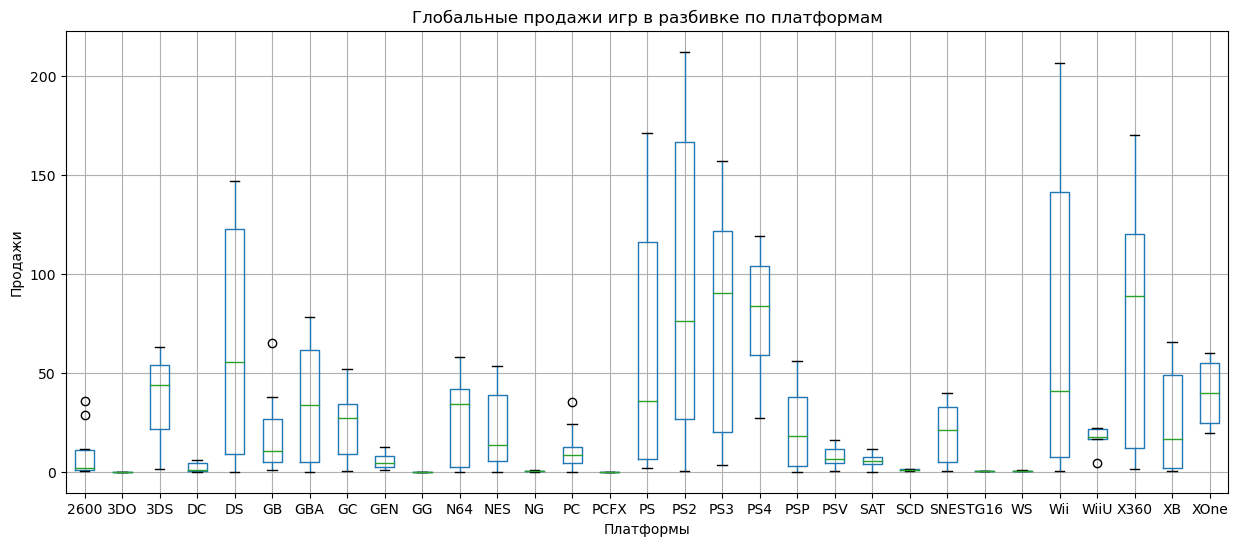

In [22]:
(
data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .boxplot(figsize=(15, 6))
)
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.ylabel('Продажи')
plt.xlabel('Платформы');

In [23]:
data.isna().agg(['sum', 'mean']).round(2).T

,sum,mean
name,0.0,0.00
platform,0.0,0.00
year_of_release,0.0,0.00
genre,0.0,0.00
na_sales,0.0,0.00
eu_sales,0.0,0.00
jp_sales,0.0,0.00
other_sales,0.0,0.00
critic_score,8576.0,0.51
user_score,6699.0,0.40


Теперь перейдем к трем оставшимся столбцам, имеющие очень много пропусков: `'critic_score'`, `'user_score'` и `'rating'`. 

`'user_score'` имеет тип object. Также в нем есть `'tbd'` - to be determined (будет определено). Это означает, что игра еще не получила своего рейтинга. Такие значения можно либо заменить на NaN, либо присвоить им маркер, который можно будет спокойно отфильтровать (например, -1). После этого можно изминить формат столбца на вещественный.

In [24]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [25]:
data.loc[data['user_score']=='tbd', 'user_score'] = -1
data['user_score'] = pd.to_numeric(data['user_score'], errors='ignore')
data[['critic_score', 'user_score', 'rating']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   critic_score  8137 non-null   float64
 1   user_score    10014 non-null  float64
 2   rating        9949 non-null   object 
dtypes: float64(2), object(1)
memory usage: 522.3+ KB


Распределение пропусков в `'critic_score'` согласуется с `'user_score'` и `'rating'`. Наблюдаются два пика: малый в 1998 году и большой в 2009-2010 гг. Причина пропусков, возможно, в оргонизации или журнале, которые составляли эти рейтинги. При том, судя по медианной оценка оценке, игры получали в основном хвалебные отзывы. График продаж среди игр без оценки подвердил догадку, что рейтинг выставлялся только играм с общими продажами от 5млн


Заполнение рейтингов пользователей и критиков медианой приведет к большим выбросам (пример ниже). Экспериментальный метод заполнения пропусков по KNN дал налогичный результат (пробовал, но не продемонстрировал). Поэтому пропущенные значения в данных колонках оставлю нетронутыми.

,count,mean,std,min,25%,50%,75%,max
critic_score,8137.0,68.967679,13.938165,13.0,60.0,71.0,79.0,98.0
user_score,10014.0,5.158288,3.717310,-1.0,2.4,6.9,8.0,9.7


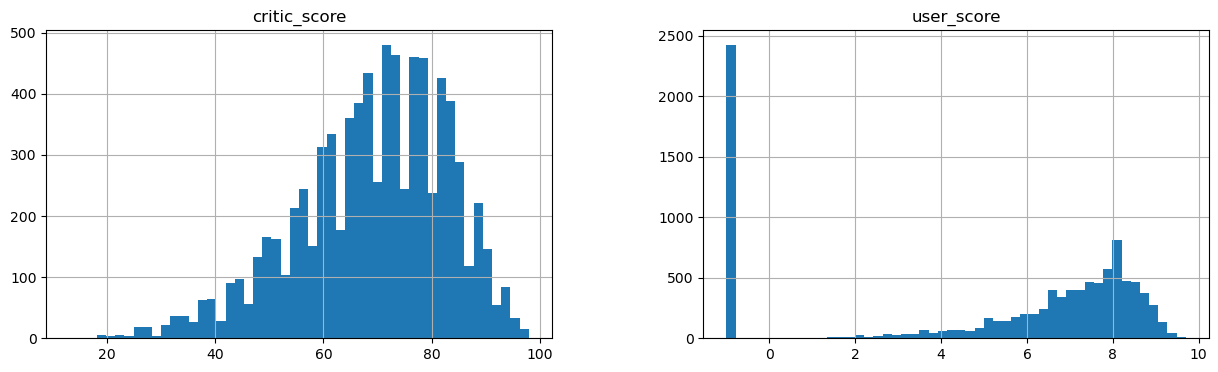

In [26]:
display(data[['critic_score', 'user_score']].describe().T)
data[['critic_score', 'user_score']].hist(bins=50, figsize=(15, 4));

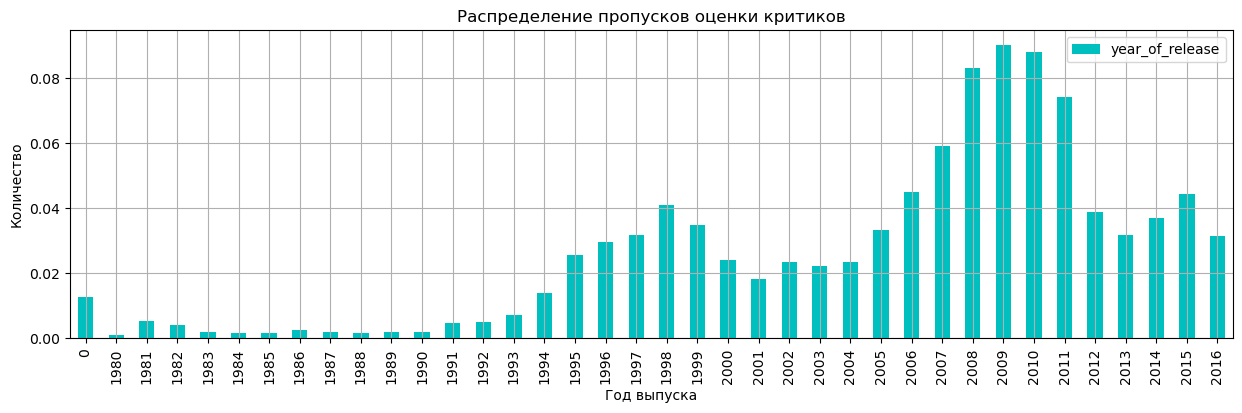

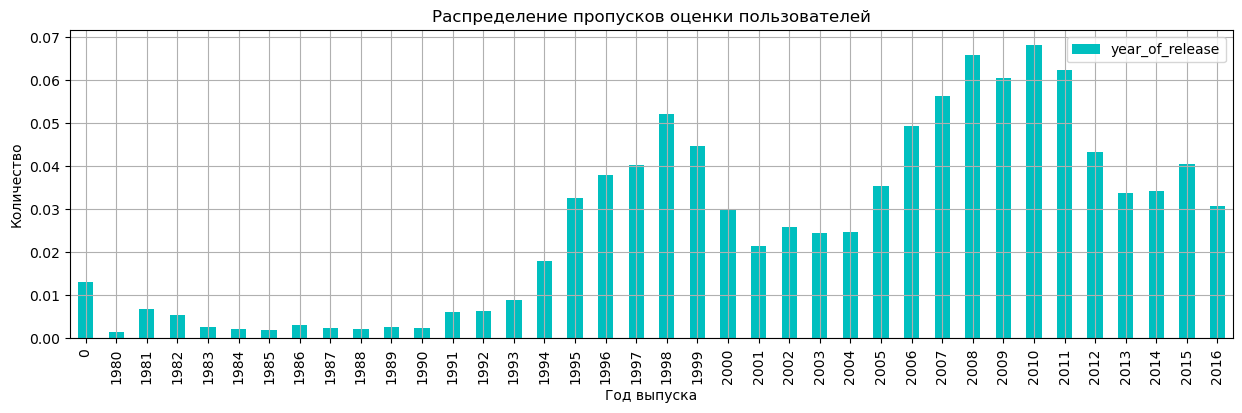

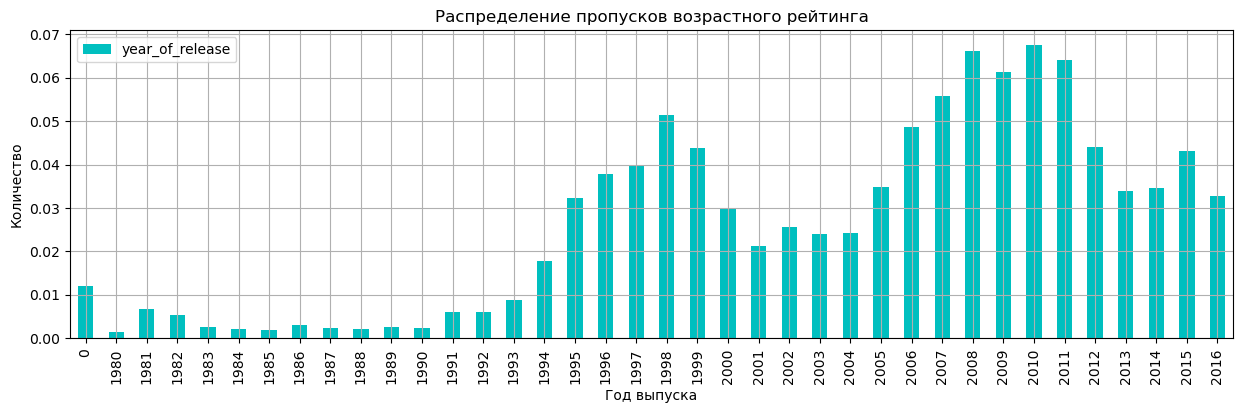

In [27]:
(
data.loc[data['critic_score'].isna(), 'year_of_release']
    .value_counts(normalize=True).reset_index().sort_values(by='index')
    .plot(x='index', y='year_of_release', kind='bar', color='c', grid=True, 
                      figsize=(15, 4), 
                      title='Распределение пропусков оценки критиков',
         xlabel='Год выпуска', ylabel='Количество')
);

(
data.loc[data['user_score'].isna(), 'year_of_release']
    .value_counts(normalize=True).reset_index().sort_values(by='index')
    .plot(x='index', y='year_of_release', kind='bar', color='c', grid=True, 
                      figsize=(15, 4), 
                      title='Распределение пропусков оценки пользователей',
         xlabel='Год выпуска', ylabel='Количество')
);

(
data.loc[data['rating'].isna(), 'year_of_release']
    .value_counts(normalize=True).reset_index()
    .sort_values(by='index')
    .plot(x='index', kind='bar', color='c', grid=True, 
                      figsize=(15, 4), 
                      title='Распределение пропусков возрастного рейтинга',
         xlabel='Год выпуска', ylabel='Количество')
);

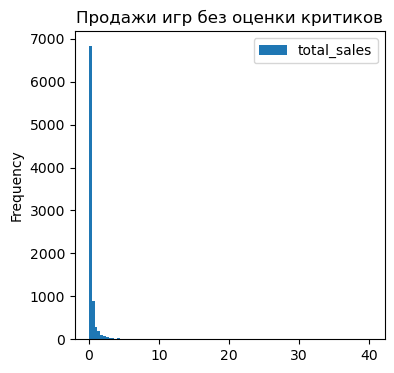

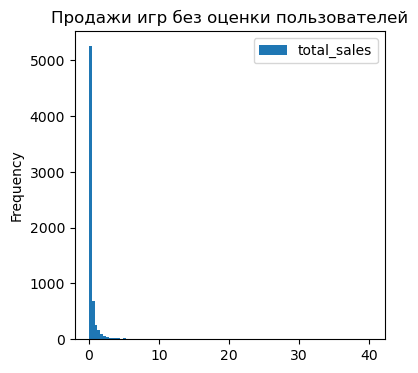

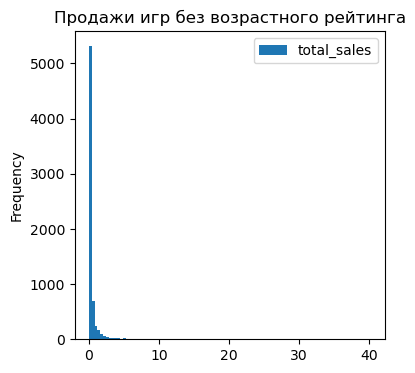

In [28]:
(
data.loc[data['critic_score'].isna(), :]
    .plot(y='total_sales', kind='hist', bins=100, figsize=(4, 4), title='Продажи игр без оценки критиков')
);

(
data.loc[data['user_score'].isna(), :]
    .plot(y='total_sales', kind='hist', bins=100, figsize=(4, 4), title='Продажи игр без оценки пользователей')
);

(
data.loc[data['rating'].isna(), :]
    .plot(y='total_sales', kind='hist', bins=100, figsize=(4, 4), title='Продажи игр без возрастного рейтинга')
);

`'rating'` выставлялся организыцией Entertainment Software Rating Board (ESRB). Расположим в порядке убывания рейтинги, встречающиеся в нашем  датасете, расшифровывая их согласно wikipedia:
- «E» («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первоначально "K-A" ("Kids to Adults").
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет. Проекты с данным рейтингом могут содержать жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику.
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года.

- «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры.
- «AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое.
- «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу

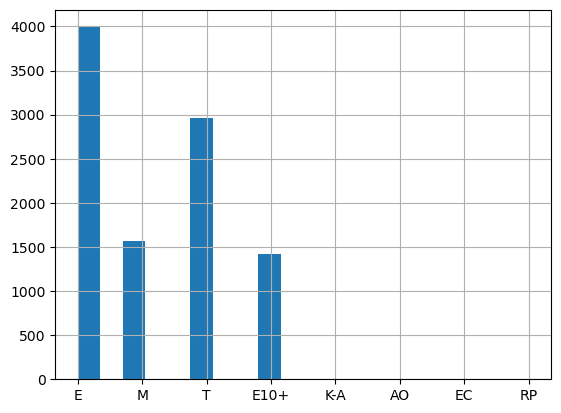

In [30]:
data['rating'].hist(bins=20, label='Распределение рейтинга в датасете');

<AxesSubplot:title={'center':'Распределение рейтинга по жанрам'}, xlabel='genre', ylabel='rating'>

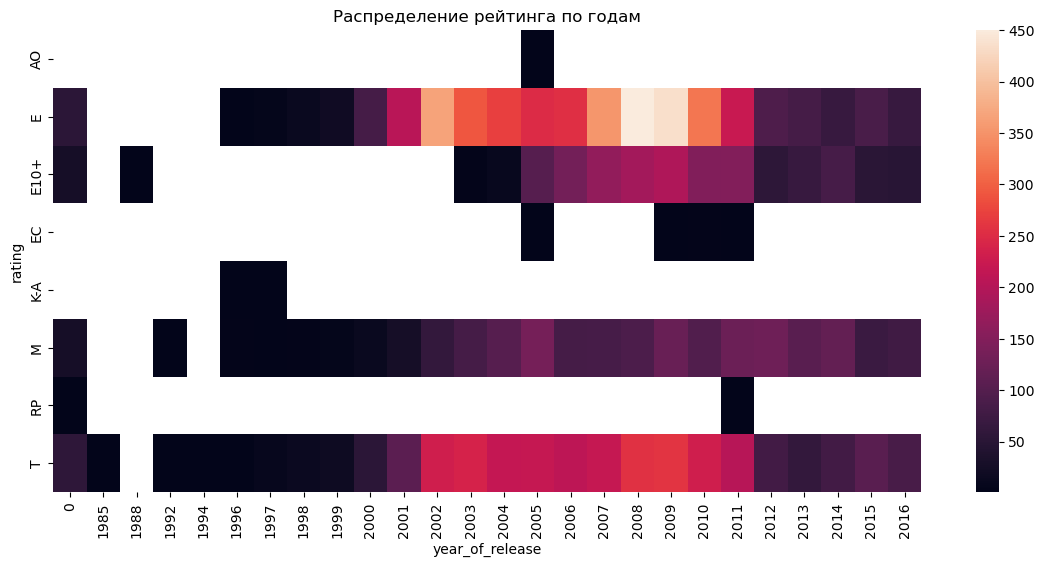

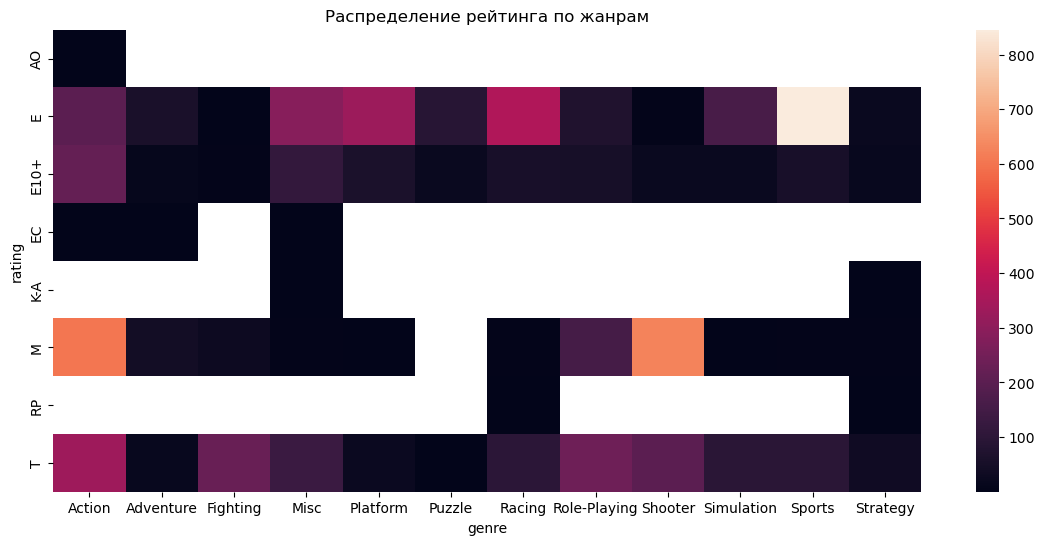

In [31]:
plt.figure(figsize=(14, 6))
plt.title('Распределение рейтинга по годам')
sns.heatmap(data.pivot_table(index='rating', columns='year_of_release', values='name', aggfunc='count'))

plt.figure(figsize=(14, 6))
plt.title('Распределение рейтинга по жанрам')
sns.heatmap(data.pivot_table(index='rating', columns='genre', values='total_sales', aggfunc='sum'))

Стоит обратить на рейтинг PR. Это игры, которые только анонсировались. Данные игры не имели года выпуска. Можно предположить, что эти игры так и не вышли. Следовательно, у этих игр нет рейтинга пользователей и критиков.

Так как ESRB основалась в 1994 году, то и рейтинги выставлялись с 1995 года (подтверждает тепловая карта). Обосновать игры с рейтингом, но выпущенные до 1994 года можно тем, что они либо перевыпускались, либо выпускались непрерывно и вплодь до основания ESRB или позже.

Также можно сделать вывод, что спортивыне игры и гонки имели рейтинг преимужественно E (для всех), шутеры - М (для взрослых), экшн игры и misc-игры отличались многообразием рейтинга на каждую возрастную категорию.

Самыми покупаемыми являются игры рейтинга Е, Т и M.


In [32]:
# Распределение суммарных продаж по рейтингу
data.groupby('rating')['total_sales'].sum().sort_values()

rating
RP         0.09
EC         1.75
AO         1.96
K-A        4.32
E10+     655.60
M       1473.79
T       1493.35
E       2435.52
Name: total_sales, dtype: float64

## Выводы по первой части проекта

- Заменил названия столбцов (привел к нижнему регистру);
- Преобразовал данные в нужные типы. Столбец `'year_of_release'` преобразовал в `int`, а `'user_score'` в `float64`
- Обработал по возможности пропуски в столбце `'year_of_release'`. В столбцах `'critic_score'`, `'user_score'` и `'rating'` пропуски оставили, так как безвредного метода их заполнения не удалось найти.
- Причины пропусков  в столбце `'year_of_release'` объясняется ошибкой заполнения таблицы, тем, что игры с рейтингом RP так и не вышли (была их презентация). Причины пропусков  в столбцах `'critic_score'`, `'user_score'` и `'rating'` объясняется тем, что рейтинг и оценка выставлялись только играм с общими продажами от 5млн. Более того, в основном `'rating'` выставлялся с 1994 года - с момента основании организации ESRB.
- Посчитал суммарные продажи во всех регионах и записали их в отдельный столбец.
- Сделал промежуточный анализ данных.

# 2. Проведение исследовательского анализа данных

Еще раз взглянем на распределение игр по годам. Для исследовательского анализа данных и планировании компании на 2017 все данные не нужны. Достаточно взять последние 3 года - за этот период подобное количество выпущенных игр. Поэтому рассматривать буду консоли актуальные с 2014 года.

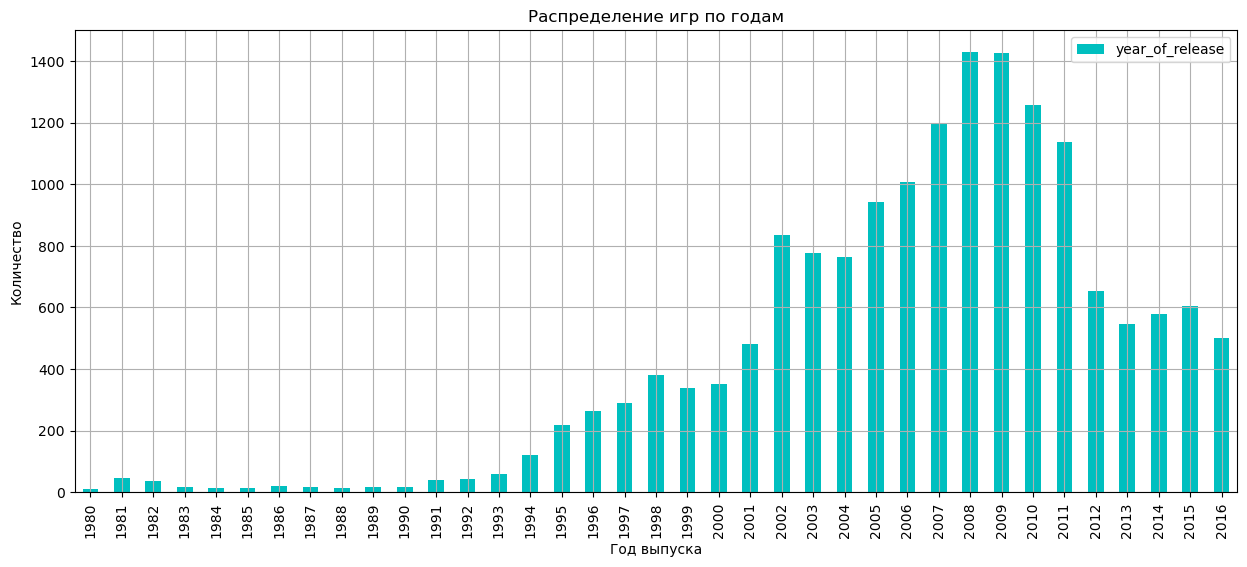

In [33]:
(
data['year_of_release'].value_counts()
                     .reset_index()
                     .query('index > 0')
                     .sort_values(by='index')
                     .plot(y='year_of_release', x='index', kind='bar', figsize=(15, 6), color='c', grid=True, 
                           title='Распределение игр по годам', 
                           xlabel='Год выпуска', ylabel='Количество')
);

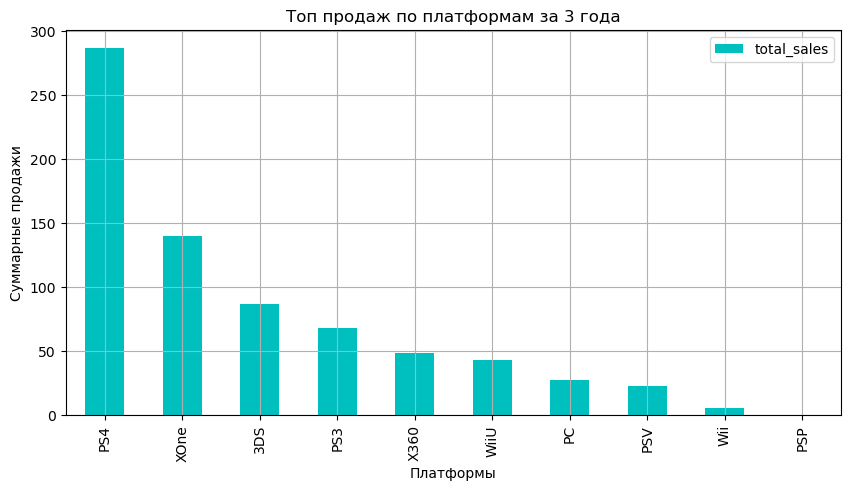

In [34]:
# Суммарные продажи за 3 года актуальных игровых платформ
(
data.query('year_of_release >= 2014')
    .groupby('platform')
    .agg({'total_sales':'sum'})
    .sort_values(by='total_sales', ascending=False)
    .merge(platform_life, on='platform', how='inner')[['total_sales' , 'min', 'max']]
    .plot(y='total_sales', kind='bar', figsize=(10, 5), color='c', grid=True, 
                           title='Топ продаж по платформам за 3 года', 
                           xlabel='Платформы', ylabel='Суммарные продажи')
);

На момент 2016 актуальными остаются 9 игровых платформ. Самый большой объем продаж за 5 лет у самой свежих PS4 и XOne, а также уже устаревших 3DS и PS3. Взглянул на продажи актуальных игровых платформ по годам.
Стоит отметить, что у всех платформ просадки по продажам в 2016 г. Это произошло из-за того, что в нем данные не за весь год.

Прохожу по всем платформам в порядке убывания их общих продаж за 3 года
- у лидера, PS4, продажи растут с каждым годом. При этом количество игр также растет. Однозначно, в рекламу игр этой платформы стоит вкладываться.
- у XOne продажи растут с каждым годом, как и у PS4, как и количество игр. Консоль вышла на смену X360, поэтому в реклому игр иэтой платформы есть смвсл вкладываться.
- 3DS хоть продажи также уменьшаются с годом, но все же они почти в 5 раз выше за неполний 2016 год (доля продаж подросла). Есть смысл вкладываться в рекламу
- у PS3 как продажи, так и количество игр неуклонно растет. Оно и не удивительно, ведь уже вышло новое поколение - PS4. Развивать данную платформу не имеет смысла.
- X360 находится в аналогичном с PS3 положении: продажи каждый год уменьшаются вдвое, как и кол-во выпускаемых игр. Нет смысла вкладываться
- WiiU и PSV конкуренты в копактном гейменге и динамика продаж у них одинаковая. Но они сильно уступаю 3DS - еще одному конкуренту. 
- Wii уже почти перестали выходить игры. Иссключаем из рассмотрения
- PC держится почти стабильно, и количство выпускаемых игр в последний год выросло

Таким образом потенциально прибыльные платформы PS4, XOne, 3DS и PC

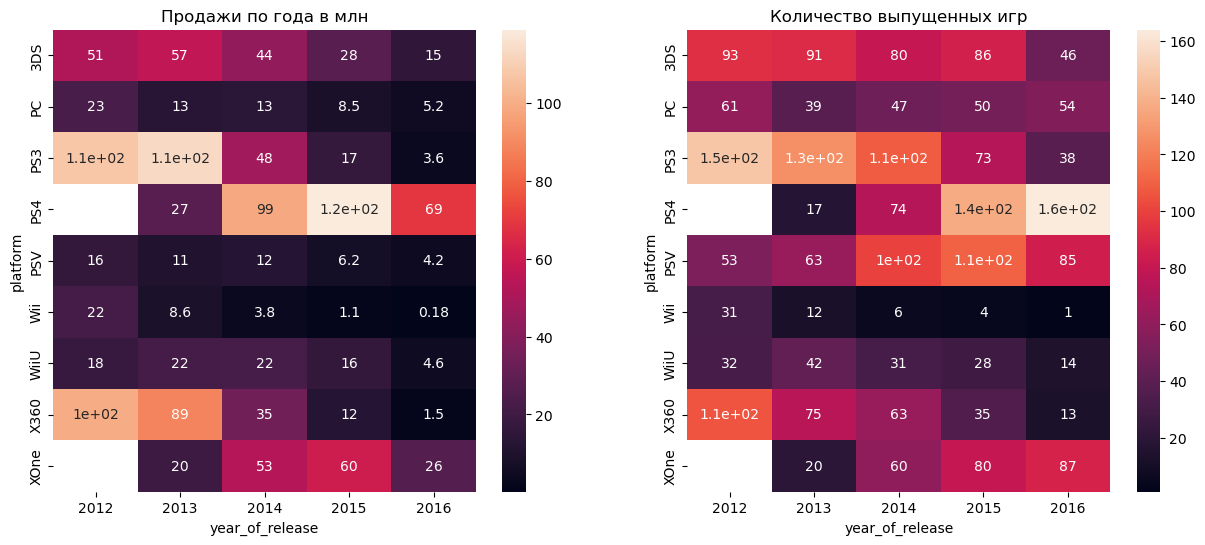

In [35]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('Продажи по года в млн')
(
sns.heatmap(
    data.query('year_of_release >= 2012 and platform != "PSP" and platform != "DS"')
    .pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum'), annot=True)
);




plt.subplot(1, 2, 2)
plt.title('Количество выпущенных игр')
(
sns.heatmap(
    data.query('year_of_release >= 2012 and platform != "PSP" and platform != "DS"')
    .pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='count'), annot=True)
);
plt.show()

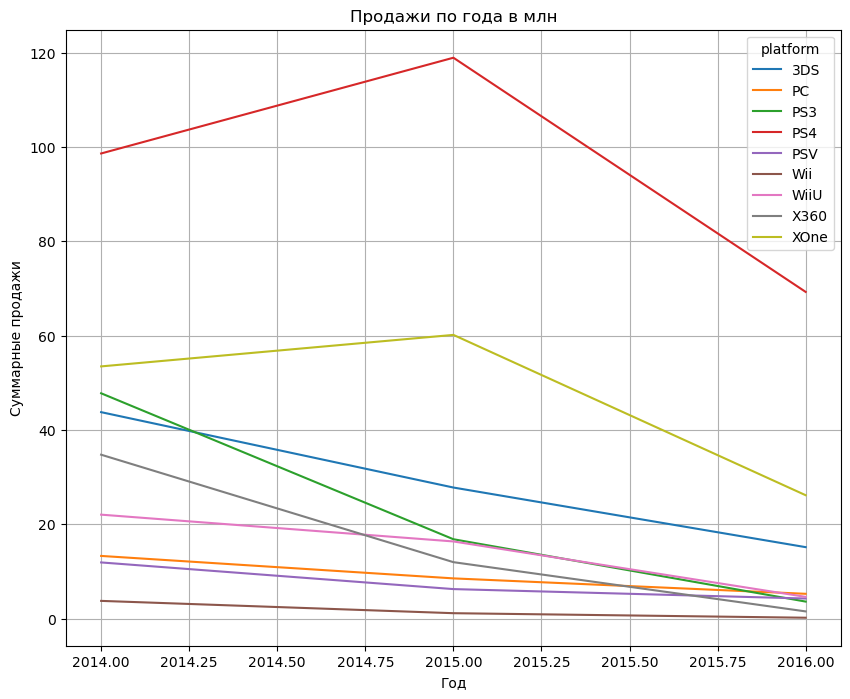

In [36]:
(
data.query('year_of_release >= 2014 and platform != "PSP" and platform != "DS"')
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot(grid=True, title='Продажи по года в млн', figsize=(10, 8), xlabel='Год', ylabel='Суммарные продажи')
);

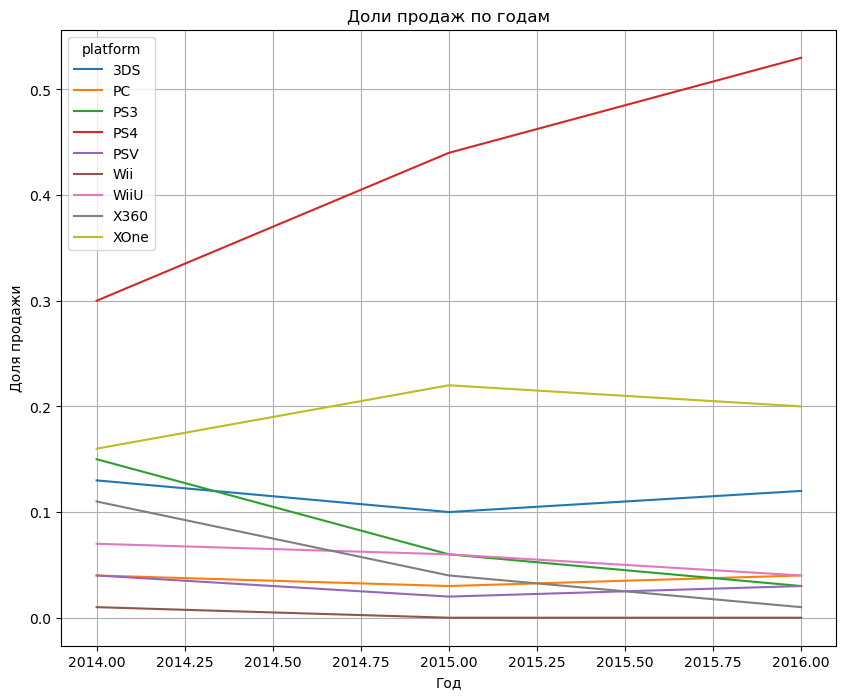

In [37]:
share_sales = (data.query('year_of_release >= 2014 and platform != "PSP" and platform != "DS"')
    .groupby(['year_of_release', 'platform'], as_index=False).agg({'total_sales':'sum'}))
share_sales['sum_year_sales'] = share_sales.groupby('year_of_release')['total_sales'].transform('sum')
share_sales['share'] = share_sales['total_sales'] / share_sales['sum_year_sales']
share_sales['share'] = share_sales['share'].round(2)

(
share_sales.pivot_table(index='year_of_release', columns='platform', values='share')
    .plot(grid=True, title='Доли продаж по годам', figsize=(10, 8), xlabel='Год', ylabel='Доля продажи')
);

Строю боксполт по актуальному периоду.

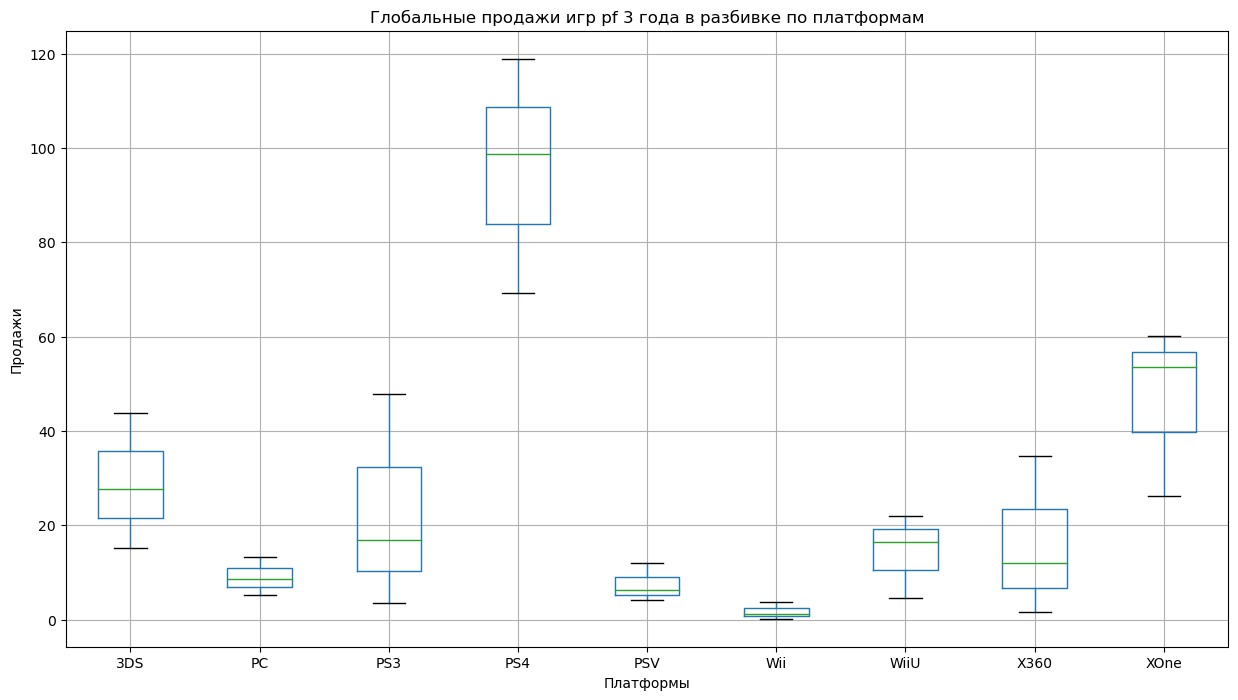

In [38]:
(
data.query('year_of_release >= 2014 and platform != "PSP" and platform != "DS"')
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .boxplot(figsize=(15, 8))
)
plt.title('Глобальные продажи игр pf 3 года в разбивке по платформам')
plt.ylabel('Продажи')
plt.xlabel('Платформы');

Смотрю, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Выбираю для этого самую популярную - PS4. Строю диаграмму рассеяния и считаю корреляцию между отзывами и продажами.

Коэффициент корреляции между продажами и оценкой критика для PS4: 0.4
Коэффициент корреляции между продажами и оценкой пользователя для PS4: -0.01


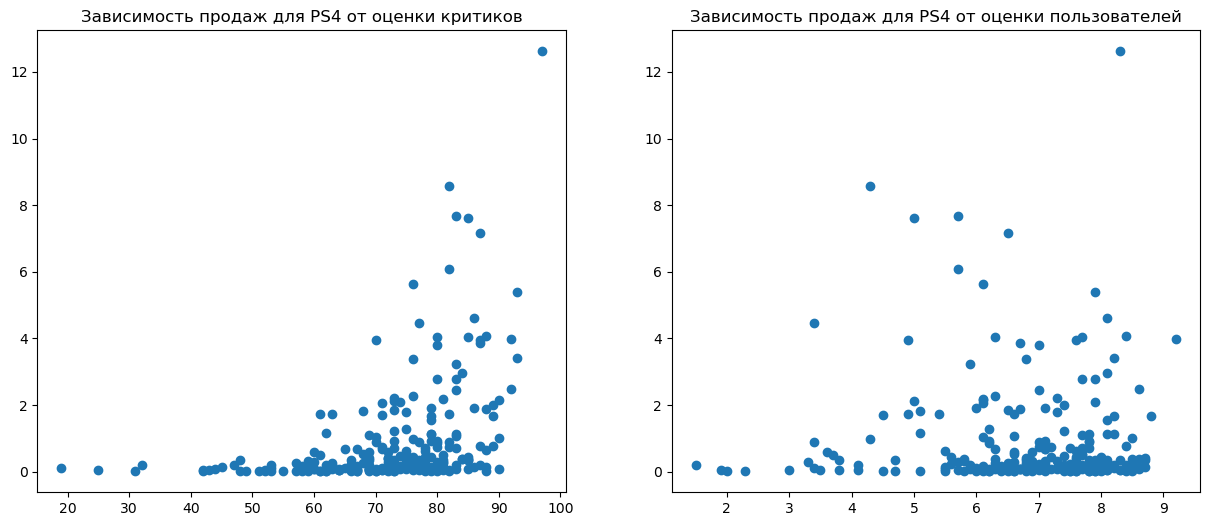

In [39]:
critic_sales = data.query('2016 >= year_of_release >= 2014 and platform == "PS4" and critic_score > 0 and total_sales > 0')
user_sales = data.query('2016 >= year_of_release >= 2014 and platform == "PS4" and user_score > 0 and total_sales > 0')

print('Коэффициент корреляции между продажами и оценкой критика для PS4:', 
      critic_sales[['critic_score', 'total_sales']].corr().loc['critic_score', 'total_sales'].round(2))
print('Коэффициент корреляции между продажами и оценкой пользователя для PS4:', 
      critic_sales[['user_score', 'total_sales']].corr().loc['user_score', 'total_sales'].round(2))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('Зависимость продаж для PS4 от оценки критиков')
plt.scatter(x=critic_sales['critic_score'], y=critic_sales['total_sales'])

plt.subplot(1, 2, 2)
plt.title('Зависимость продаж для PS4 от оценки пользователей')
plt.scatter(x=user_sales['user_score'], y=user_sales['total_sales'])

plt.show()

Между продажами игр и оценкой критиков существует связь: чем они выше, тем лучше продажи. Об этом и говорит коэффициент корреляции Пирсона 0.41 (правда, он определяет лишь линейную корреляцию, а она в нашем случае не линейная). Между продажами игр и оценкой пользователя связь не наблюдается. 

Подобная связь наблюдается и на других платформах: XOne, 3DS и PC

Коэффициент корреляции между продажами и оценкой критика для PS4: 0.4
Коэффициент корреляции между продажами и оценкой пользователя для PS4: -0.01


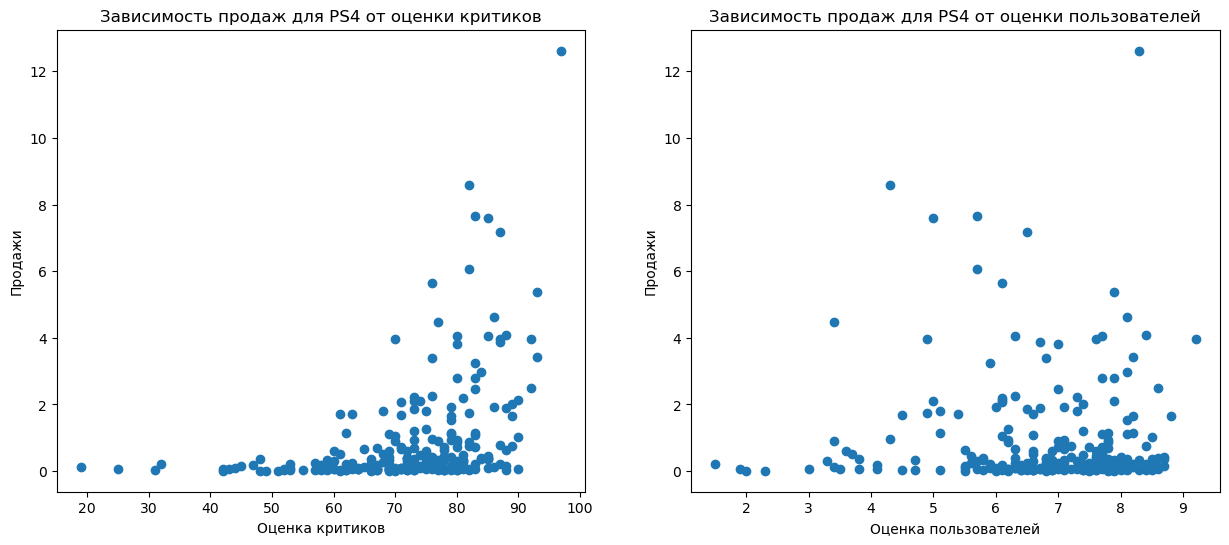

Коэффициент корреляции между продажами и оценкой критика для XOne: 0.43
Коэффициент корреляции между продажами и оценкой пользователя для XOne: -0.01


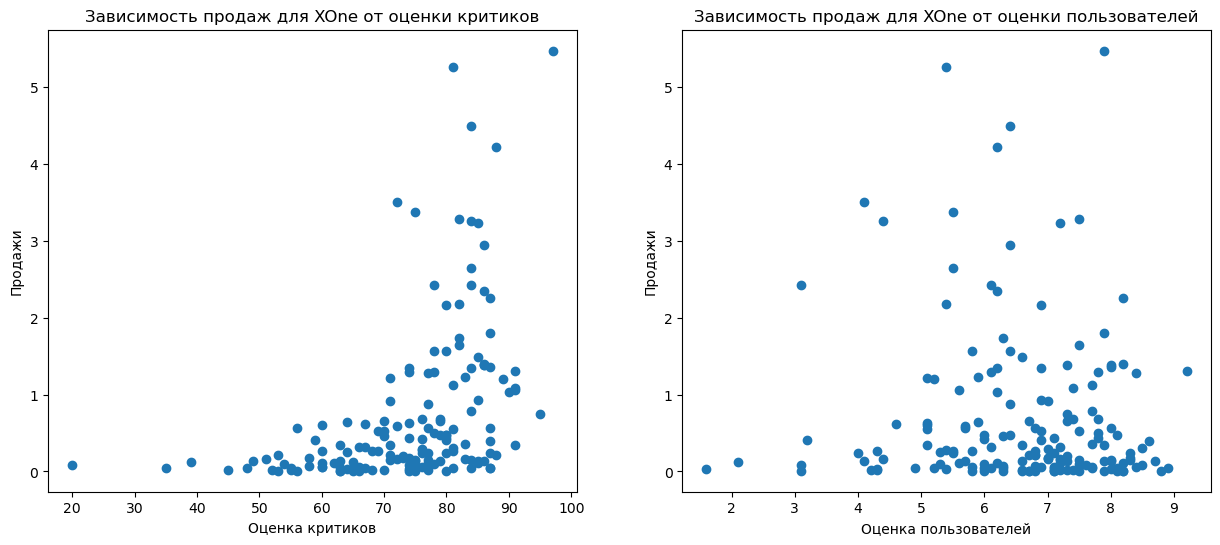

Коэффициент корреляции между продажами и оценкой критика для 3DS: 0.31
Коэффициент корреляции между продажами и оценкой пользователя для 3DS: 0.27


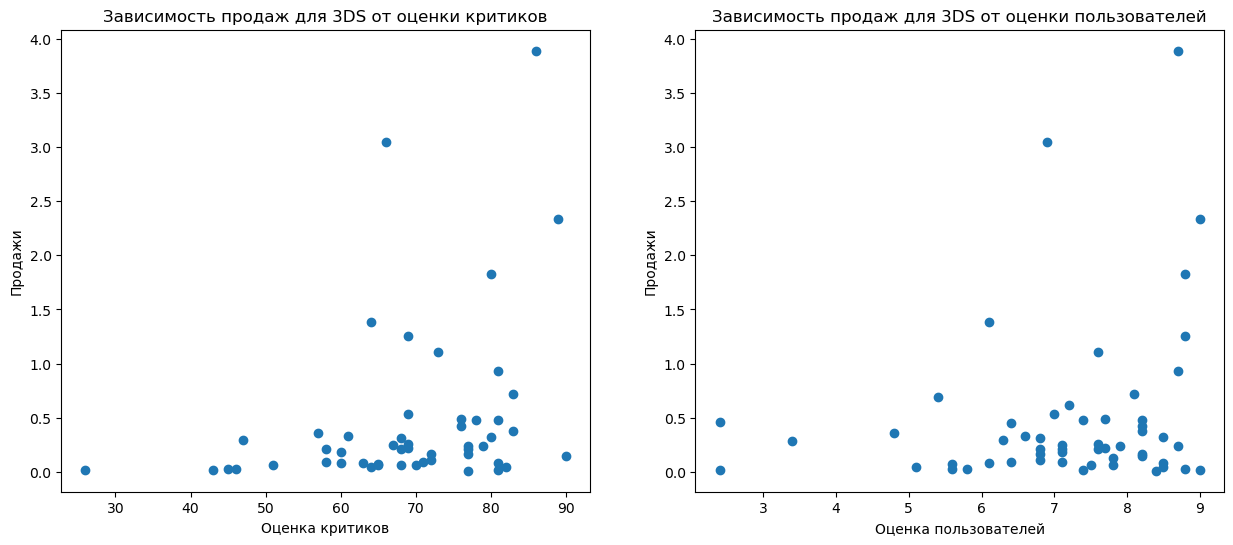

Коэффициент корреляции между продажами и оценкой критика для PC: 0.17
Коэффициент корреляции между продажами и оценкой пользователя для PC: -0.09


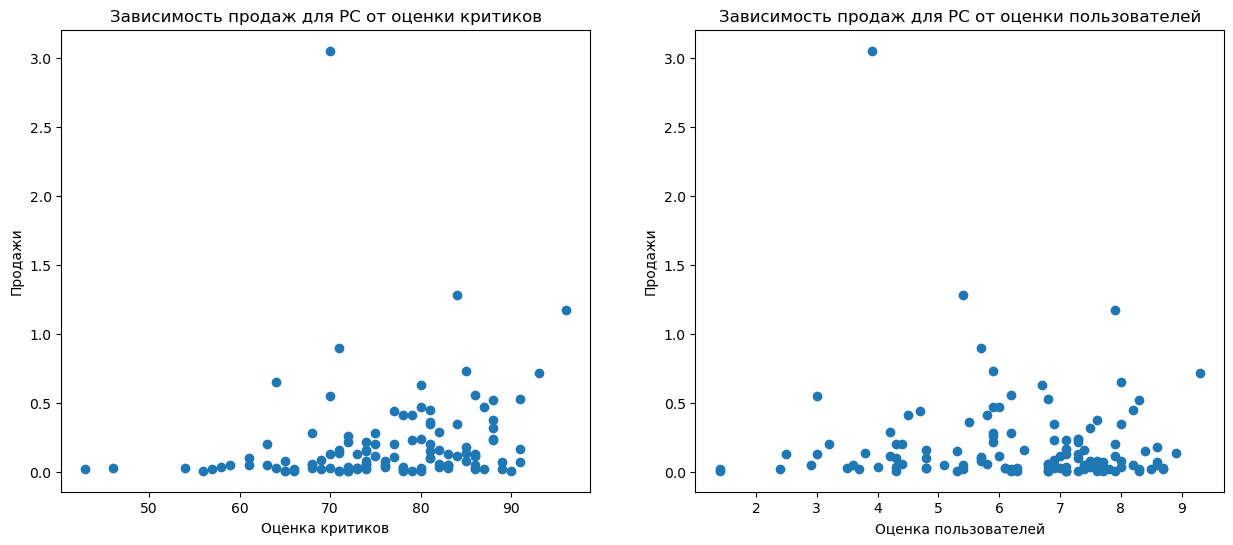

In [40]:
for i in ['PS4', 'XOne', '3DS', 'PC']:
    critic_sales = data.query('2016 >= year_of_release >= 2014 and platform == @i and critic_score > 0 and total_sales > 0')
    user_sales = data.query('2016 >= year_of_release >= 2014 and platform == @i and user_score > 0 and total_sales > 0')

    print(f'Коэффициент корреляции между продажами и оценкой критика для {i}:', 
          critic_sales[['critic_score', 'total_sales']].corr().loc['critic_score', 'total_sales'].round(2))
    print(f'Коэффициент корреляции между продажами и оценкой пользователя для {i}:', 
          critic_sales[['user_score', 'total_sales']].corr().loc['user_score', 'total_sales'].round(2))

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title(f'Зависимость продаж для {i} от оценки критиков')
    plt.scatter(x=critic_sales['critic_score'], y=critic_sales['total_sales'])
    plt.xlabel('Оценка критиков')
    plt.ylabel('Продажи')

    plt.subplot(1, 2, 2)
    plt.title(f'Зависимость продаж для {i} от оценки пользователей')
    plt.scatter(x=user_sales['user_score'], y=user_sales['total_sales'])
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи')

    plt.show()

Смотрю связь между медианными продажами и жанрами для каждой перспективной платформы за актуальный период.

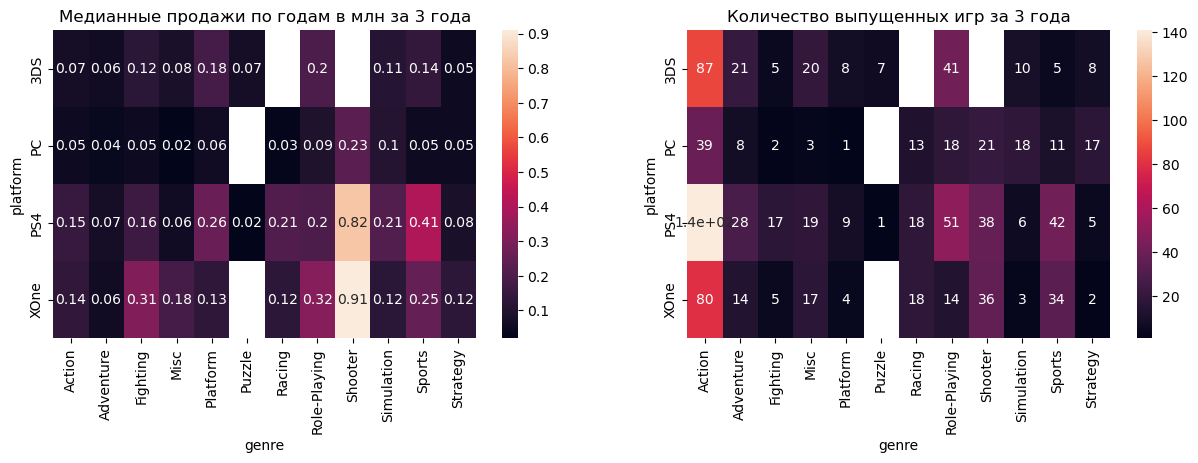

In [41]:
actual_plarform = ['PS4', 'XOne', '3DS', 'PC']

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title('Медианные продажи по годам в млн за 3 года')
(
sns.heatmap(
    data.query('year_of_release >= 2014 and platform in @actual_plarform')
    .pivot_table(index='platform', columns='genre', values='total_sales', aggfunc='median'), annot=True)
);




plt.subplot(1, 2, 2)
plt.title('Количество выпущенных игр за 3 года')
(
sns.heatmap(
    data.query('year_of_release >= 2014 and platform in @actual_plarform')
    .pivot_table(index='platform', columns='genre', values='total_sales', aggfunc='count'), annot=True)
);

plt.show()

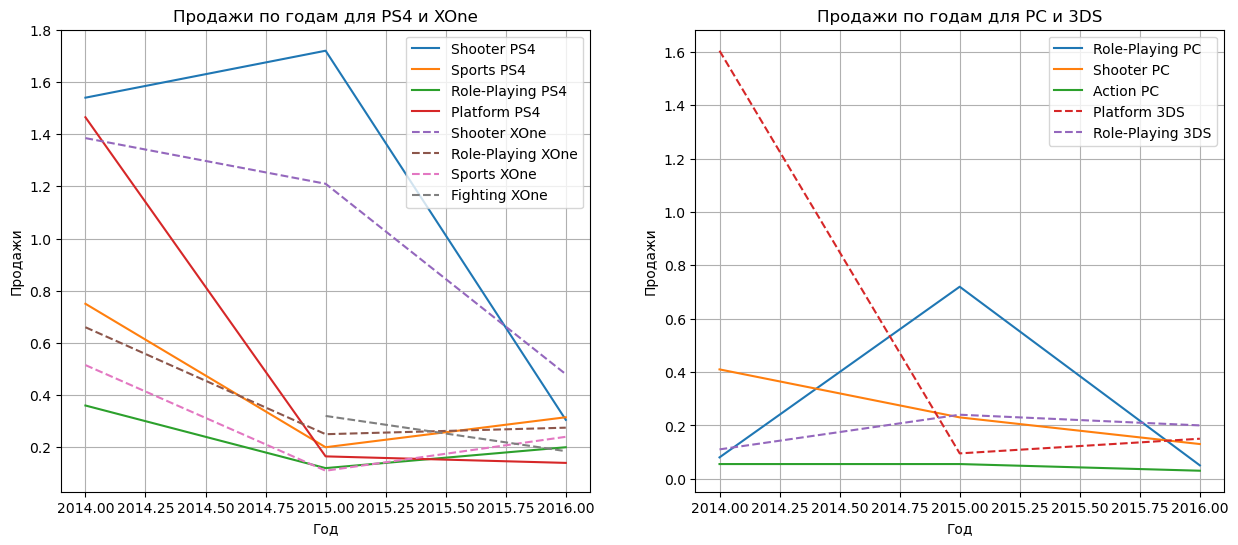

In [42]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('Продажи по годам для PS4 и XOne')
(data.query('year_of_release >= 2014 and platform == "PS4" and genre == "Shooter"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Shooter PS4'));
(data.query('year_of_release >= 2014 and platform == "PS4" and genre == "Sports"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Sports PS4'));
(data.query('year_of_release >= 2014 and platform == "PS4" and genre == "Role-Playing"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Role-Playing PS4'));
(data.query('year_of_release >= 2014 and platform == "PS4" and genre == "Platform"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Platform PS4'));

(data.query('year_of_release >= 2014 and platform == "XOne" and genre == "Shooter"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Shooter XOne', style='--'));
(data.query('year_of_release >= 2014 and platform == "XOne" and genre == "Role-Playing"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Role-Playing XOne', style='--'));
(data.query('year_of_release >= 2014 and platform == "XOne" and genre == "Sports"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Sports XOne', style='--'));
(data.query('year_of_release >= 2014 and platform == "XOne" and genre == "Fighting"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Fighting XOne', style='--'));
plt.xlabel('Год')
plt.ylabel('Продажи')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Доля продаж по годам для PC и PSV')
(data.query('year_of_release >= 2014 and platform == "PC" and genre == "Role-Playing"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Role-Playing PC'));
(data.query('year_of_release >= 2014 and platform == "PC" and genre == "Shooter"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Shooter PC'));
(data.query('year_of_release >= 2014 and platform == "PC" and genre == "Action"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Action PC'));

(data.query('year_of_release >= 2014 and platform == "3DS" and genre == "Platform"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Platform 3DS', style='--'));
plt.title('Продажи по годам для PC и 3DS')
(data.query('year_of_release >= 2014 and platform == "3DS" and genre == "Role-Playing"')
 .groupby('year_of_release')['total_sales'].median()  
 .plot(label='Role-Playing 3DS', style='--'));
plt.xlabel('Год')
plt.ylabel('Продажи')
plt.grid()
plt.legend();

А также связь между медианными продажами и жанрами для каждой безперспективной платформы за актуальный период

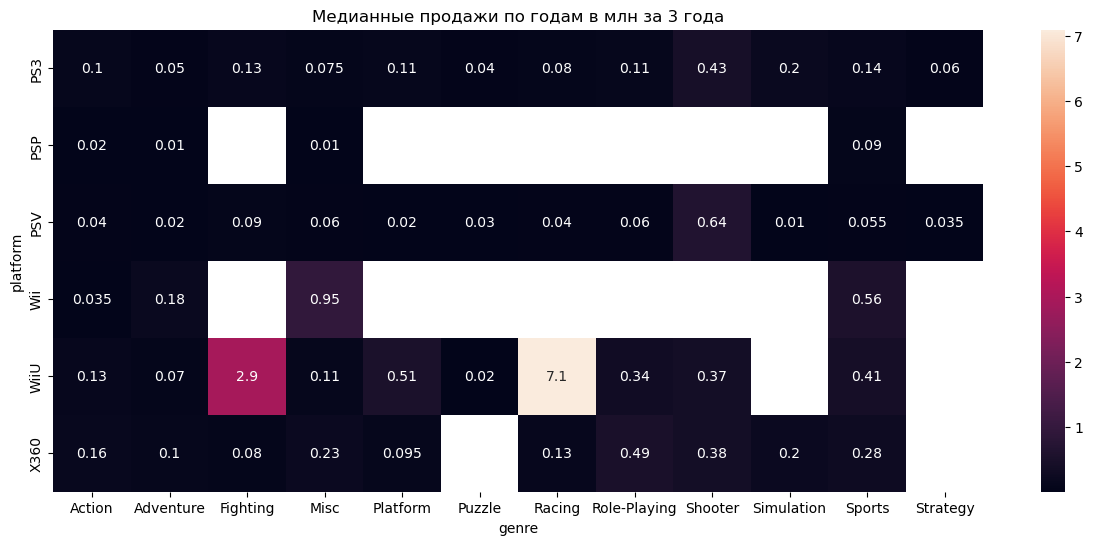

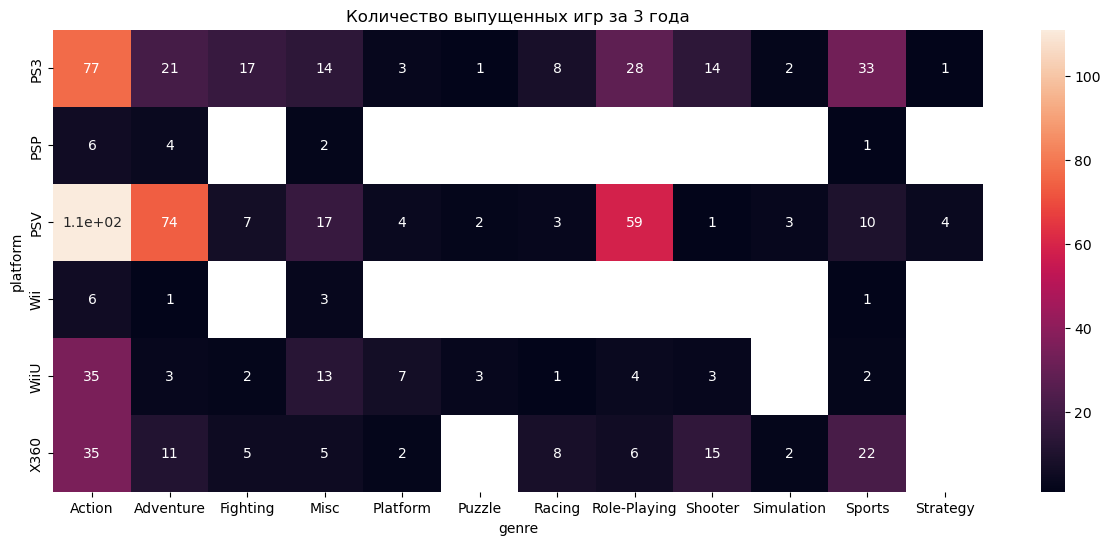

In [43]:
actual_plarform = ['PS4', 'XOne', '3DS', 'PC']

plt.figure(figsize=(15, 6))
#plt.subplot(1, 2, 1)
plt.title('Медианные продажи по годам в млн за 3 года')
(
sns.heatmap(
    data.query('year_of_release >= 2014 and platform not in @actual_plarform')
    .pivot_table(index='platform', columns='genre', values='total_sales', aggfunc='median'), annot=True)
);



plt.figure(figsize=(15, 6))
#plt.subplot(1, 2, 2)
plt.title('Количество выпущенных игр за 3 года')
(
sns.heatmap(
    data.query('year_of_release >= 2014 and platform not in @actual_plarform')
    .pivot_table(index='platform', columns='genre', values='total_sales', aggfunc='count'), annot=True)
);

plt.show()

Самые популярные жанры на перспективных платформах:
- для PS4: Shooter, Sports, Platform и Role-Playing. 
- для XOne: Shooter, Fighting, Sports и Role-Playing, 
- для 3DS: Role-Playing и Platform
- для PC: Shooter.

Наименьшие продажи на перспективных платформах:
- Stratege и Adventures для 3DS
- Racing и Misc для PC
- Puzzle и Misc для PS4
- Adventures для XOne


Самые популярные жанры на безперспективных платформах:
- Racing и Fighting для WiiU
- Misc для Wii

## Промежуточный вывод

Выяснил, что наиболее перспективные для развития платформы: PS4, XOne, 3DS, PC

Самые перспективные жанры:
- для PS4: Shooter, Sports, Platform и Role-Playing. 
- для XOne: Shooter, Fighting, Sports и Role-Playing, 
- для 3DS: Role-Playing и Platform
- для PC: Shooter.

Между оценкой критиков и продажами существует нелинейная прямая связь. Между оценкой пользователей и продажами корелляции нет.

# 3. Составление портрета пользователя каждого региона

Определяю для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5).

Самые популярные платформы за все время:


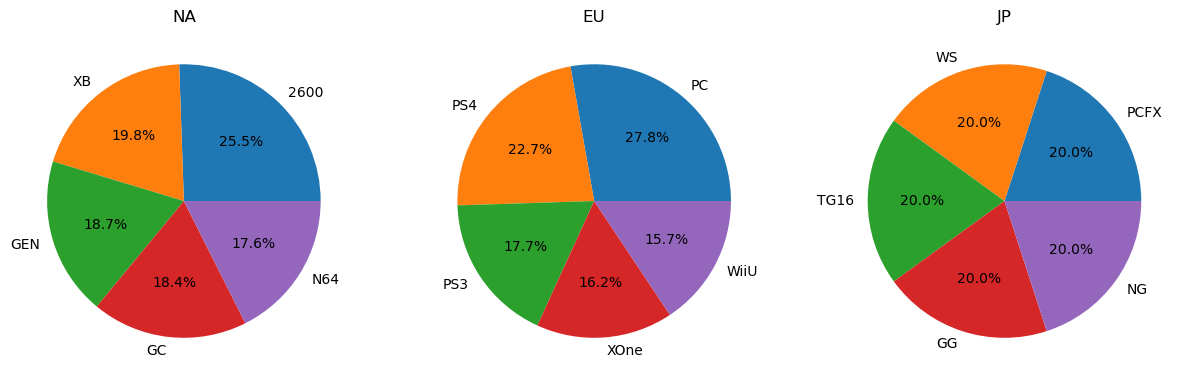

Самые популярные платформы за последние 3 года:


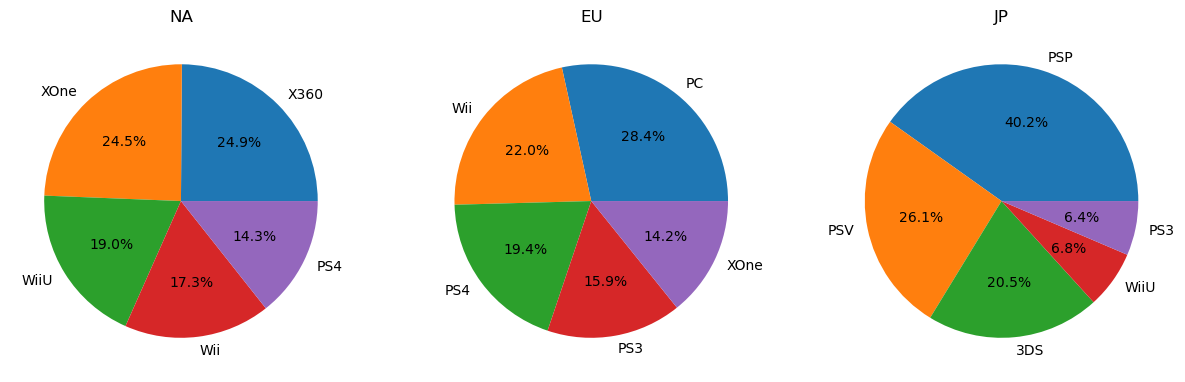

In [44]:
na_eu_jp_eu_sales = data[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'platform']].groupby('platform').sum()
na_eu_jp_eu_sales['na_sales'] = na_eu_jp_eu_sales['na_sales'] / na_eu_jp_eu_sales['total_sales']
na_eu_jp_eu_sales['eu_sales'] = na_eu_jp_eu_sales['eu_sales'] / na_eu_jp_eu_sales['total_sales']
na_eu_jp_eu_sales['jp_sales'] = na_eu_jp_eu_sales['jp_sales'] / na_eu_jp_eu_sales['total_sales']
na_eu_jp_eu_sales = na_eu_jp_eu_sales[['na_sales', 'eu_sales', 'jp_sales']].round(2)
na_eu_jp_eu_sales.columns = ['na_share', 'eu_share', 'jp_share']

print('Самые популярные платформы за все время:')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for ind, case in enumerate(['na_share', 'eu_share', 'jp_share']):
    (ax[ind].pie(na_eu_jp_eu_sales[case].sort_values(ascending=False).head(), 
         labels=na_eu_jp_eu_sales.sort_values(by=case, ascending=False).head().index, 
         autopct='%1.1f%%', radius=1))
    ax[ind].set_title(case[:2].upper())
plt.show()


na_eu_jp_eu_sales = data[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'platform', 'year_of_release']].query('year_of_release >= 2014').groupby('platform').sum()
na_eu_jp_eu_sales['na_sales'] = na_eu_jp_eu_sales['na_sales'] / na_eu_jp_eu_sales['total_sales']
na_eu_jp_eu_sales['eu_sales'] = na_eu_jp_eu_sales['eu_sales'] / na_eu_jp_eu_sales['total_sales']
na_eu_jp_eu_sales['jp_sales'] = na_eu_jp_eu_sales['jp_sales'] / na_eu_jp_eu_sales['total_sales']
na_eu_jp_eu_sales = na_eu_jp_eu_sales[['na_sales', 'eu_sales', 'jp_sales']].round(2)
na_eu_jp_eu_sales.columns = ['na_share', 'eu_share', 'jp_share']
print('Самые популярные платформы за последние 3 года:')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for ind, case in enumerate(['na_share', 'eu_share', 'jp_share']):
    (ax[ind].pie(na_eu_jp_eu_sales[case].sort_values(ascending=False).head(), 
         labels=na_eu_jp_eu_sales.sort_values(by=case, ascending=False).head().index, 
         autopct='%1.1f%%', radius=1))
    ax[ind].set_title(case[:2].upper())
plt.show()

В лидерах по общим продажам за 3 года является PS4 (в 2 раза больше ближайшего конкурента - XOne). Однако, более 15% занимают 'Другие регионы' (это больше общих продаж pf 3 года таких платформ, как WiiU, PC, PSV, Wii, PSP). Поэтому в системе координат 'NA', 'EU' и 'JP', абстрагировавшись от других регионов, данная платформа не входят в топ-2.

В других ргеионах самыми популярными платформами являются PS4, PS3, X360, XOne, PSV (то есть XOne нет и в топ-3). Самыми полпулярными жанрами являются Platform, Action, Racing, Sports.

,na_sales,eu_sales,jp_sales,other_sales,total_sales
platform,,,,,
PS4,0.34,0.45,0.05,0.15,286.75
XOne,0.58,0.33,0.00,0.09,139.75
3DS,0.26,0.19,0.51,0.04,86.68
PS3,0.32,0.37,0.16,0.14,68.18
X360,0.59,0.32,0.00,0.09,48.22
WiiU,0.45,0.31,0.17,0.07,42.98
PC,0.27,0.66,0.00,0.07,27.05
PSV,0.11,0.16,0.65,0.08,22.40
Wii,0.41,0.51,0.00,0.08,5.07


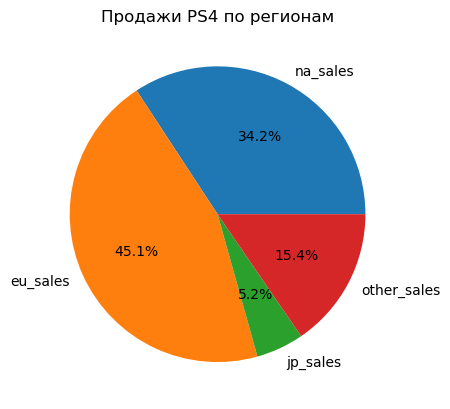

In [45]:
other_sales = data[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'platform', 'year_of_release', 'other_sales']].query('year_of_release >= 2014').groupby('platform').sum()
other_sales['na_sales'] = other_sales['na_sales'] / other_sales['total_sales']
other_sales['eu_sales'] = other_sales['eu_sales'] / other_sales['total_sales']
other_sales['jp_sales'] = other_sales['jp_sales'] / other_sales['total_sales']
other_sales['other_sales'] = other_sales['other_sales'] / other_sales['total_sales']
display(other_sales[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']].sort_values(by='total_sales', ascending=False).round(2))


plt.pie(other_sales.loc['PS4', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']], 
          labels=other_sales[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].columns, 
          autopct='%1.1f%%', radius=1)
plt.title('Продажи PS4 по регионам');

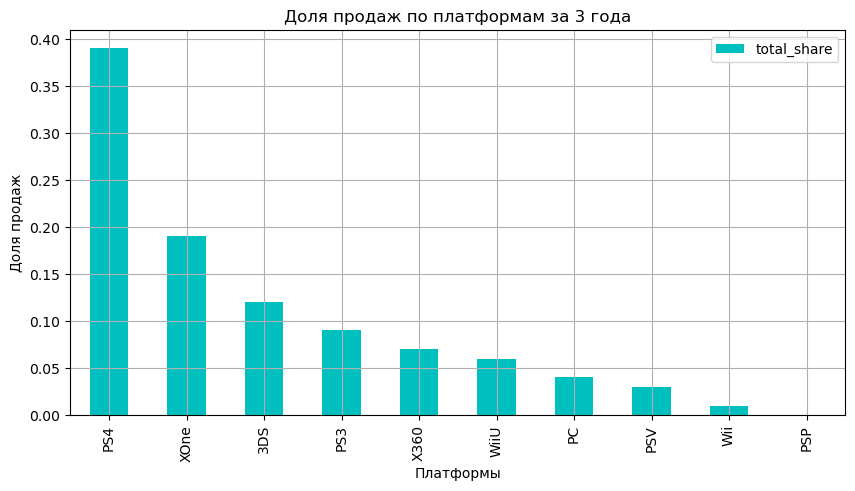

In [46]:
other_sales = data[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'platform', 'year_of_release', 'other_sales']].query('year_of_release >= 2014').groupby('platform').sum()
other_sales['na_sales'] = other_sales['na_sales'] / other_sales['total_sales']
other_sales['eu_sales'] = other_sales['eu_sales'] / other_sales['total_sales']
other_sales['jp_sales'] = other_sales['jp_sales'] / other_sales['total_sales']
other_sales['other_sales'] = other_sales['other_sales'] / other_sales['total_sales']
other_sales['total_share'] = other_sales['total_sales'] / other_sales['total_sales'].sum()

(
other_sales[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_share']]
    .sort_values(by='total_share', ascending=False).round(2)
    .plot(y='total_share', kind='bar', figsize=(10, 5), color='c', grid=True, 
                           title='Доля продаж по платформам за 3 года', 
                           xlabel='Платформы', ylabel='Доля продаж')
);

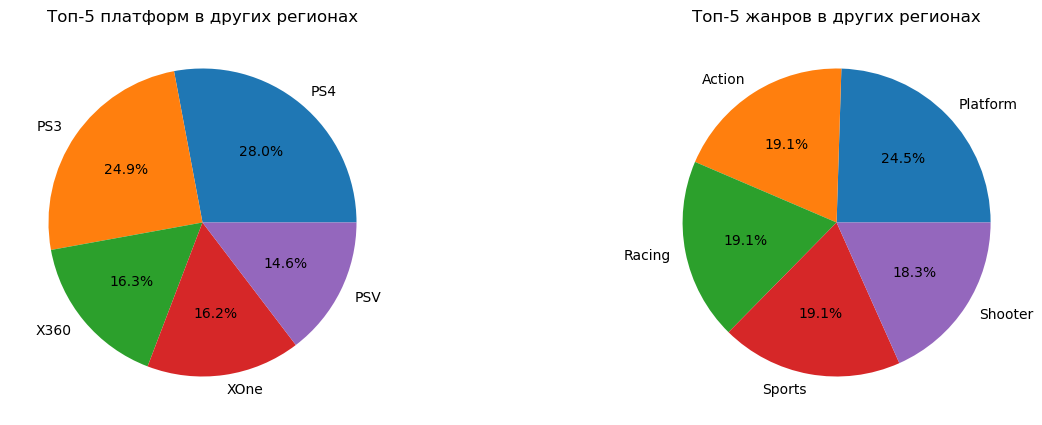

In [47]:
other_sales
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
(ax[0].pie(other_sales['other_sales'].sort_values(ascending=False).head(), 
         labels=other_sales.sort_values(by='other_sales', ascending=False).head().index, 
         autopct='%1.1f%%', radius=1))
ax[0].set_title('Топ-5 платформ в других регионах')

other_sales1 = data[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'genre', 'year_of_release', 'other_sales']].query('year_of_release >= 2014').groupby('genre').median()
other_sales1['na_sales'] = other_sales1['na_sales'] / other_sales1['total_sales']
other_sales1['eu_sales'] = other_sales1['eu_sales'] / other_sales1['total_sales']
other_sales1['jp_sales'] = other_sales1['jp_sales'] / other_sales1['total_sales']
other_sales1['other_sales'] = other_sales1['other_sales'] / other_sales1['total_sales']
(ax[1].pie(other_sales1['other_sales'].sort_values(ascending=False).head(), 
         labels=other_sales1.sort_values(by='other_sales', ascending=False).head().index, 
         autopct='%1.1f%%', radius=1))
ax[1].set_title('Топ-5 жанров в других регионах')
plt.show()

#fig, ax = plt.subplots(1, 3, figsize=(15, 5))

Определяю для пользователя каждого региона (NA, EU, JP) самые популярные жанры (топ-5).

Самые популярные жанры за все время:


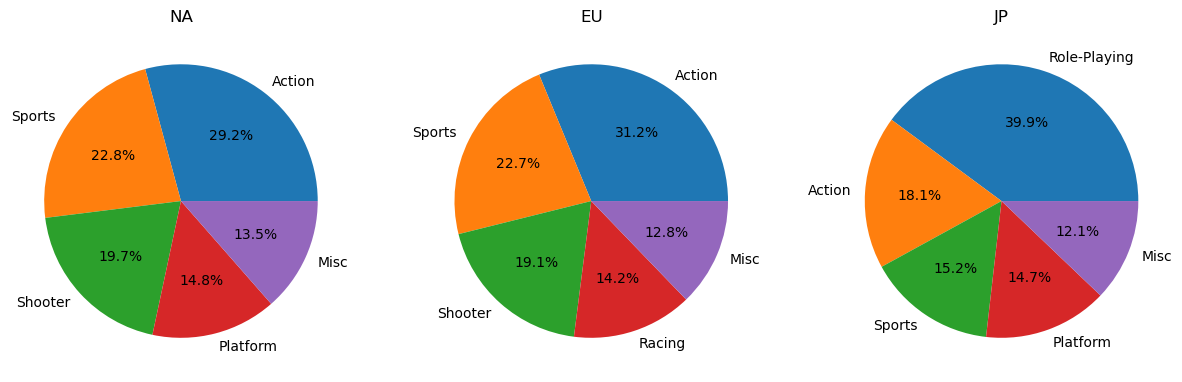

Самые популярные жанры за последние 3 года:


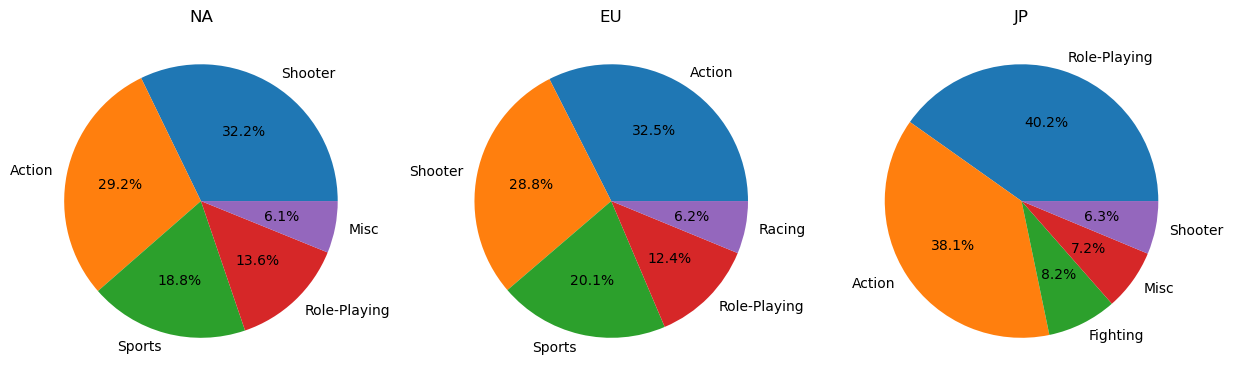

In [48]:
na_eu_jp_eu_genre = data[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'genre']].groupby('genre').sum()

print('Самые популярные жанры за все время:')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for ind, case in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    (ax[ind].pie(na_eu_jp_eu_genre[case].sort_values(ascending=False).head(), 
         labels=na_eu_jp_eu_genre.sort_values(by=case, ascending=False).head().index, 
         autopct='%1.1f%%', radius=1))
    ax[ind].set_title(case[:2].upper())
plt.show()


na_eu_jp_eu_genre = data[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'genre', 'year_of_release']].query('year_of_release >= 2014').groupby('genre').sum()

print('Самые популярные жанры за последние 3 года:')
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for ind, case in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    (ax[ind].pie(na_eu_jp_eu_genre[case].sort_values(ascending=False).head(), 
         labels=na_eu_jp_eu_genre.sort_values(by=case, ascending=False).head().index, 
         autopct='%1.1f%%', radius=1))
    ax[ind].set_title(case[:2].upper())
plt.show()

Смотрю как влияет рейтинг в каждом регионе. Для удобства присвоим рейтингу цифру - чем выще цифра, тем выше возрастной рейтинг. Рейтинг RP оставляю без изменений, так как он означает, что рейтинг еще не получен. Так как последний рейтинг был введен в 2005г, то будем учитывать игры от 2006 года.

В Европе и Америке имеются два пика: большой у рейтинга E и малый у M. Рейтинги EC и АО почти не пользуются спросом. В Японии меньший пик приходится на рейтинг T. При этом, наблюдается немного продаж в рейтинге PR. Суммарные продажи игр без рейтинга для всех регионов велики. Для Японии суммарные продажи игр без рейтинга вдвое больше, чем для Е.

Однако в разрезе последних 3 лет ситуация другая. В Америке и Европе большой интерес вызывают игры для взрослых. Начиная с рейтинга E10+ с повышением возрастного рейтинга увеличивается и продажи. В промежутке между E и E10+ корреляция обратная. В Японии наибольший интерес вызывают игры с рейтигами Е и Т. Во всех странах отсутвуют продажи самого взрослого рейтинга AO, рейтинга EC и RP. Игры без рейтинга занимают существенную долю продаж в каждом регионе

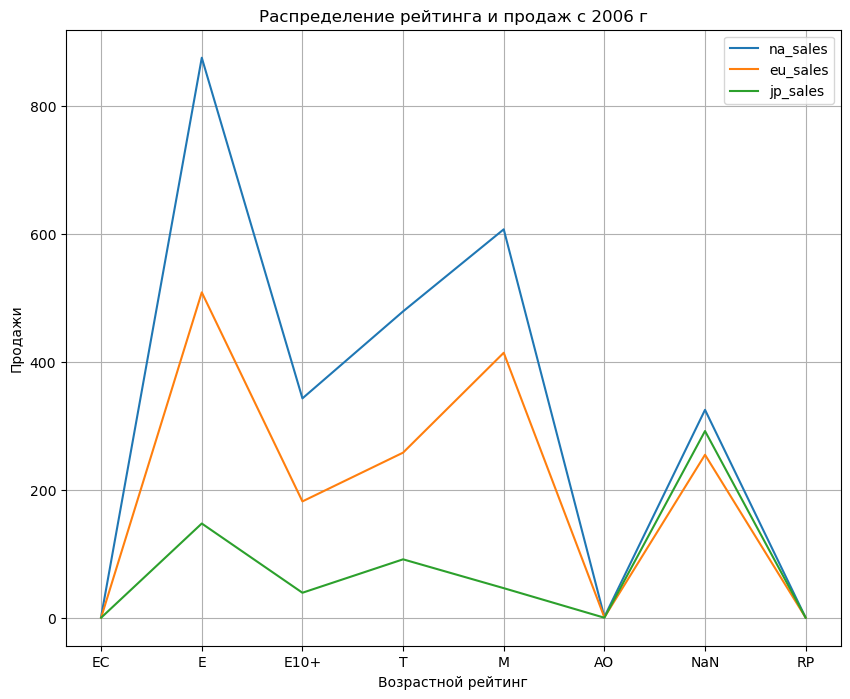

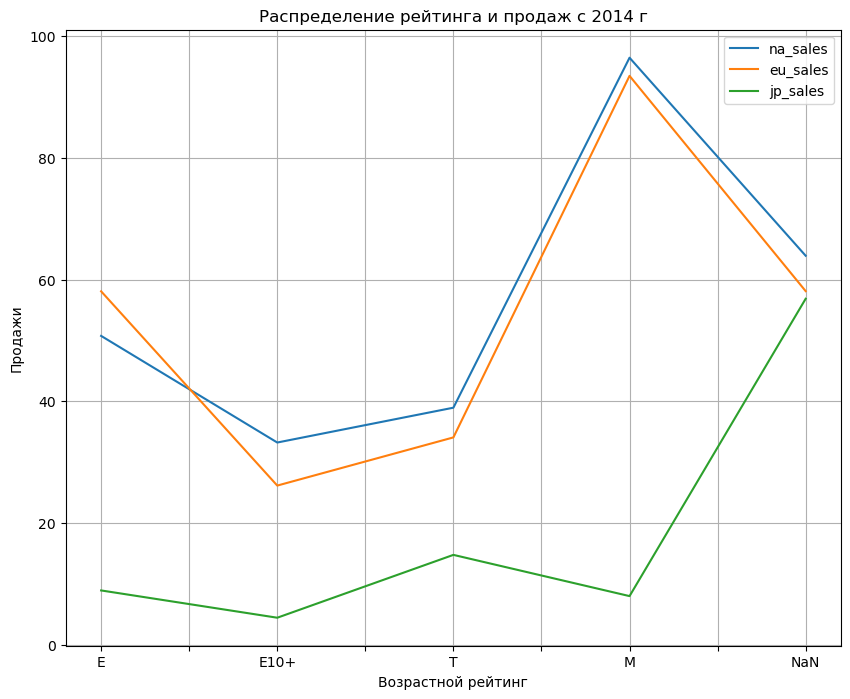

In [49]:
na_eu_jp_eu_genre = data[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'rating', 'year_of_release']]
na_eu_jp_eu_genre['rating'] = na_eu_jp_eu_genre['rating'].fillna(6)
na_eu_jp_eu_genre = na_eu_jp_eu_genre.query('year_of_release >= 2005').groupby('rating').sum()
na_eu_jp_eu_genre = (na_eu_jp_eu_genre.rename(index={'EC':0, 'E':1, 'K-A':1, 'E10+':2, 'T':3, 'M':4, 'AO':5})
                     .groupby('rating').sum()
                     .rename(index={0:'EC', 1:'E', 2:'E10+', 3:'T', 4:'M', 5:'AO', 6:'NaN'}))


na_eu_jp_eu_genre[['na_sales', 'eu_sales', 'jp_sales']].plot(title='Распределение рейтинга и продаж с 2006 г',
                                 figsize=(10, 8), xlabel='Возрастной рейтинг', ylabel='Продажи', grid=True);


na_eu_jp_eu_genre_actual = data[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'rating', 'year_of_release']]
na_eu_jp_eu_genre_actual['rating'] = na_eu_jp_eu_genre_actual['rating'].fillna(6)    
na_eu_jp_eu_genre_actual = na_eu_jp_eu_genre_actual.query('year_of_release >= 2014').groupby('rating').sum()

na_eu_jp_eu_genre_actual = (na_eu_jp_eu_genre_actual.rename(index={'EC':0, 'E':1, 'K-A':1, 'E10+':2, 'T':3, 'M':4, 'AO':5})
                            .groupby('rating').sum()
                            .rename(index={0:'EC', 1:'E', 2:'E10+', 3:'T', 4:'M', 5:'AO', 6:'NaN'}))

na_eu_jp_eu_genre_actual[['na_sales', 'eu_sales', 'jp_sales']].plot(title='Распределение рейтинга и продаж с 2014 г',
                                 figsize=(10, 8), xlabel='Возрастной рейтинг', ylabel='Продажи', grid=True);

## Промежуточный вывод

За последние 3 года самыми популярными жанрами 
- в Америке являются: Action, Shooter, Sports, Role-Playing, Misc
- в Европе: Action, Shooter, Sports, Role-Playing, Misc
- в Японии: Role-Playing, Action, Misc, Shooter, Fighting

Топ пять консолей:
- в Америке: X360, XOne, Wii, WiiU, PS4
- в Европе: PC, PS4, PS3, Wii, XOne
- в Японии: PSP, PSV, 3DS, WiiU, PS3 (предпочитают мобильный форум-фактор консолей)

Во всех странах самые популярные возрастные рейтинги игр Е, Т и М и игры без рейтинга

# 4. Проверка гипотез

-Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

-Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза №1: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Альтернативная гипотеза №1: средние пользовательские рейтинги платформ Xbox One и PC разные

То есть решаем задачи о равенстве средних двух генеральных совокупностей.

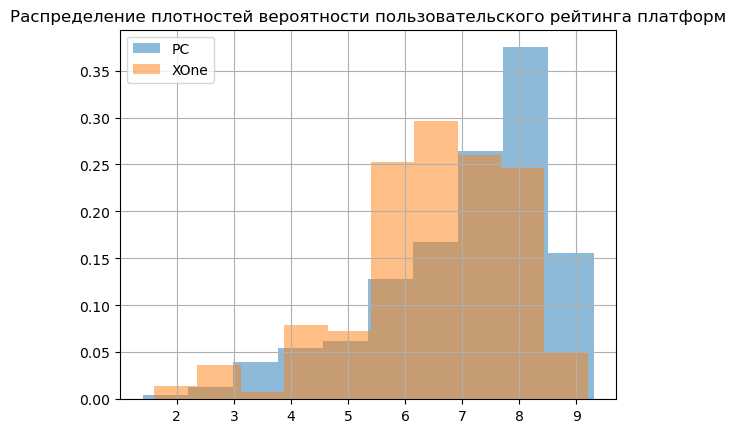

In [50]:
array1 = data.dropna(subset=['platform', 'user_score']).query('platform == "PC" and user_score > 0')['user_score']
array2 = data.dropna(subset=['platform', 'user_score']).query('platform == "XOne" and user_score > 0')['user_score']
array1.hist(label='PC', bins=10, density=True, alpha=0.5)
array2.hist(label='XOne', bins=10, density=True, alpha=0.5)
plt.legend()
plt.title('Распределение плотностей вероятности пользовательского рейтинга платформ');

In [51]:
(
data.dropna(subset=['platform', 'user_score']).query('(platform == "XOne" or platform == "PC") and user_score > 0')
    .groupby('platform')['user_score'].describe()
)

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PC,770.0,7.062468,1.529963,1.4,6.2,7.5,8.2,9.3
XOne,182.0,6.521429,1.380941,1.6,5.8,6.8,7.5,9.2


Избавляюсь от выбрасов

In [52]:
sigma1 = array1.quantile(0.75) - array1.quantile(0.25)
left1 = array1.quantile(0.25) - 1.5 * sigma1
array1 = array1[array1 > left1]

sigma2 = array2.quantile(0.75) - array2.quantile(0.25)
left2 = array2.quantile(0.25) - 1.5 * sigma2
array2 = array2[array2 > left2]

750
174


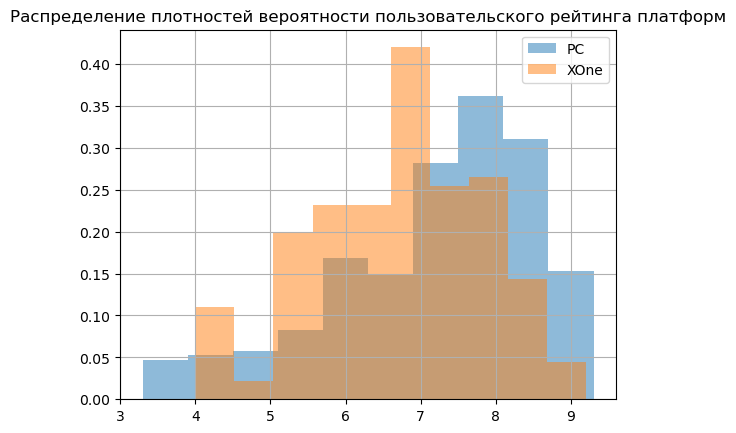

In [53]:
array1.hist(label='PC', bins=10, density=True, alpha=0.5)
array2.hist(label='XOne', bins=10, density=True, alpha=0.5)
print(len(array1))
print(len(array2))
plt.legend()
plt.title('Распределение плотностей вероятности пользовательского рейтинга платформ');

In [54]:
result1 = st.ttest_ind(array1, array2, equal_var=False)
alfa = 0.05
print('p-value:', result1.pvalue)
if result1.pvalue < alfa:
    print('Нулевая гипотеза №1 ложна')
else:
    print('Нулевая гипотеза №1 верна')

p-value: 1.7614471632853341e-06
Нулевая гипотеза №1 ложна


Нулевая гипотеза №2: пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые

Альтернативная гипотеза №2: пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

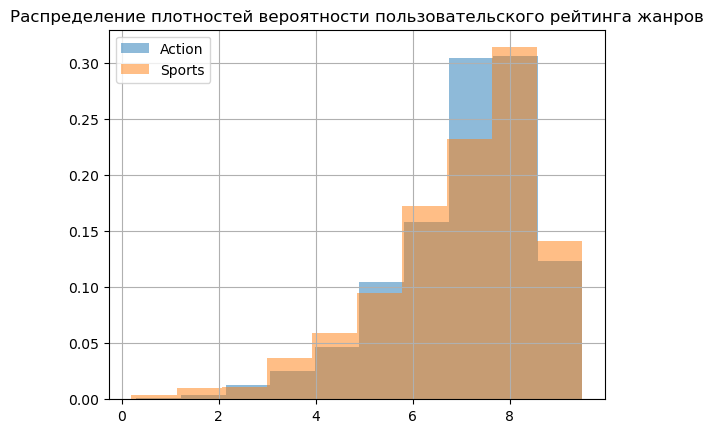

In [55]:
array3 = data.dropna(subset=['genre', 'user_score']).query('genre == "Action" and user_score > 0')['user_score']
array4 = data.dropna(subset=['genre', 'user_score']).query('genre == "Sports" and user_score > 0')['user_score']

array3.hist(label='Action', bins=10, density=True, alpha=0.5)
array4.hist(label='Sports', bins=10, density=True, alpha=0.5)
plt.legend()
plt.title('Распределение плотностей вероятности пользовательского рейтинга жанров');

Избавляюсь от выбрасов

In [56]:
sigma3 = array3.quantile(0.75) - array3.quantile(0.25)
left3 = array3.quantile(0.25) - 1.5 * sigma3
array3 = array3[array3 > left3]

sigma4 = array4.quantile(0.75) - array4.quantile(0.25)
left4 = array4.quantile(0.25) - 1.5 * sigma4
array4 = array4[array4 > left4]

1772
1073


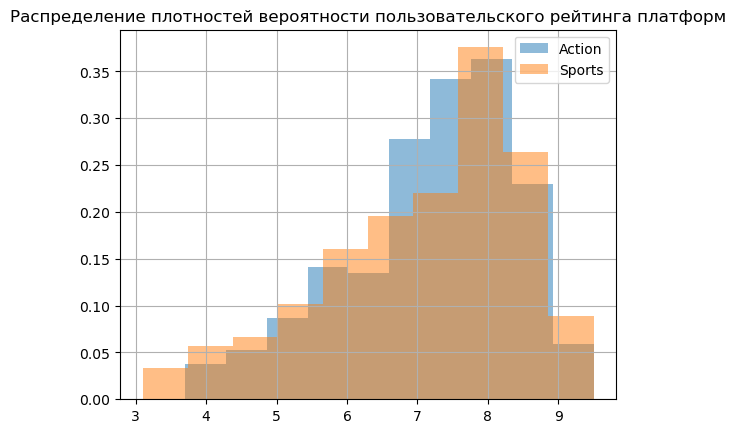

In [57]:
array3.hist(label='Action', bins=10, density=True, alpha=0.5)
array4.hist(label='Sports', bins=10, density=True, alpha=0.5)
print(len(array3))
print(len(array4))

plt.legend()
plt.title('Распределение плотностей вероятности пользовательского рейтинга платформ');

In [58]:
result2 = st.ttest_ind(array3, array4, equal_var=False)
alfa = 0.05
print('p-value:', result2.pvalue)
if result2.pvalue < alfa:
    print('Нулевая гипотеза №2 ложна')
else:
    print('Нулевая гипотеза №2 верна')

p-value: 0.06680118245746675
Нулевая гипотеза №2 верна


## Промежуточный вывод

Гипотезы о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые и средние пользовательские рейтинги жанров Action и Sports разные НЕ подвердились

# 5. Общий вывод

Целью данного проекта являлось выявление определяющих успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании

Сначала провел подготовку данных:
- Заменил названия столбцов (приведите к нижнему регистру);
- Преобразовал данные в нужные типы. Столбец `'year_of_release'` преобразовал в `int`, а `'user_score'` в `float64`
- Обработал по возможности пропуски в столбце `'year_of_release'` - те игры, в названиях которых есть упоминание о годе релиза. В столбцах `'critic_score'`, `'user_score'` и `'rating'` пропуски оставили, так как безвредного метода их заполнения не удалось найти.
- Причины пропусков  в столбце `'year_of_release'` объясняется ошибкой заполнения таблицы, и тем, что игры с рейтингом RP могли  не выйти (была их презентация). Причины пропусков  в столбцах `'critic_score'`, `'user_score'` и `'rating'` объясняется тем, что рейтинг и оценка выставлялись только играм с общими продажами от 5млн. Более того, в основном `'rating'` выставлялся с 1994 года - с момента основании организации ESRB.
- Посчитал суммарные продажи во всех регионах и записали их в отдельный столбец.


После провели исследовательский анализ данных. Выяснил, что наиболее перспективные для развития платформы: PS4, XOne, 3DS, PC.

Самые перспективные жанры:
- для PS4: Shooter, Sports, Platform и Role-Playing. 
- для XOne: Shooter, Fighting, Sports и Role-Playing, 
- для 3DS: Role-Playing и Platform
- для PC: Shooter

Между оценкой критиков и продажами существует нелинейная прямая связь. Между оценкой пользователей и продажами корелляции нет. То есть геймеры мало доверяют оценке других геймеров, но доверяют оценкам критиков (обзоры, стримеры).

За последние 3 года самыми популярными жанрами 
- в Америке являются: Action, Shooter, Sports, Role-Playing, Misc
- в Европе: Action, Shooter, Sports, Role-Playing, Misc
- в Японии: Role-Playing, Action, Misc, Shooter, Fighting
- В других регионах: Platform, Action, Racing, Sports.

Топ пять консолей в актуальный период:
- в Америке: X360, XOne, Wii, WiiU, PS4
- в Европе: PC, PS4, PS3, Wii, XOne
- в Японии: PSP, PSV, 3DS, WiiU, PS3 (предпочитают мобильный форум-фактор консолей)
- в других регионах: PS4, PS3, X360, XOne, PSV

Во всех странах самые популярные возрастные рейтинги игр Е, Т и М


Проверил гипотезы о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые и средние пользовательские рейтинги жанров Action и Sports разные. Обе гипотезы не подвердились.